### Examining Verkko Haplotypes Non-B DNA Annotations Overall
These plots all deal with overall genome-wide annotation metrics of non-B DNA
- Trying to get an overall view of non-B DNA
- Note: G4s here are all Q > 19

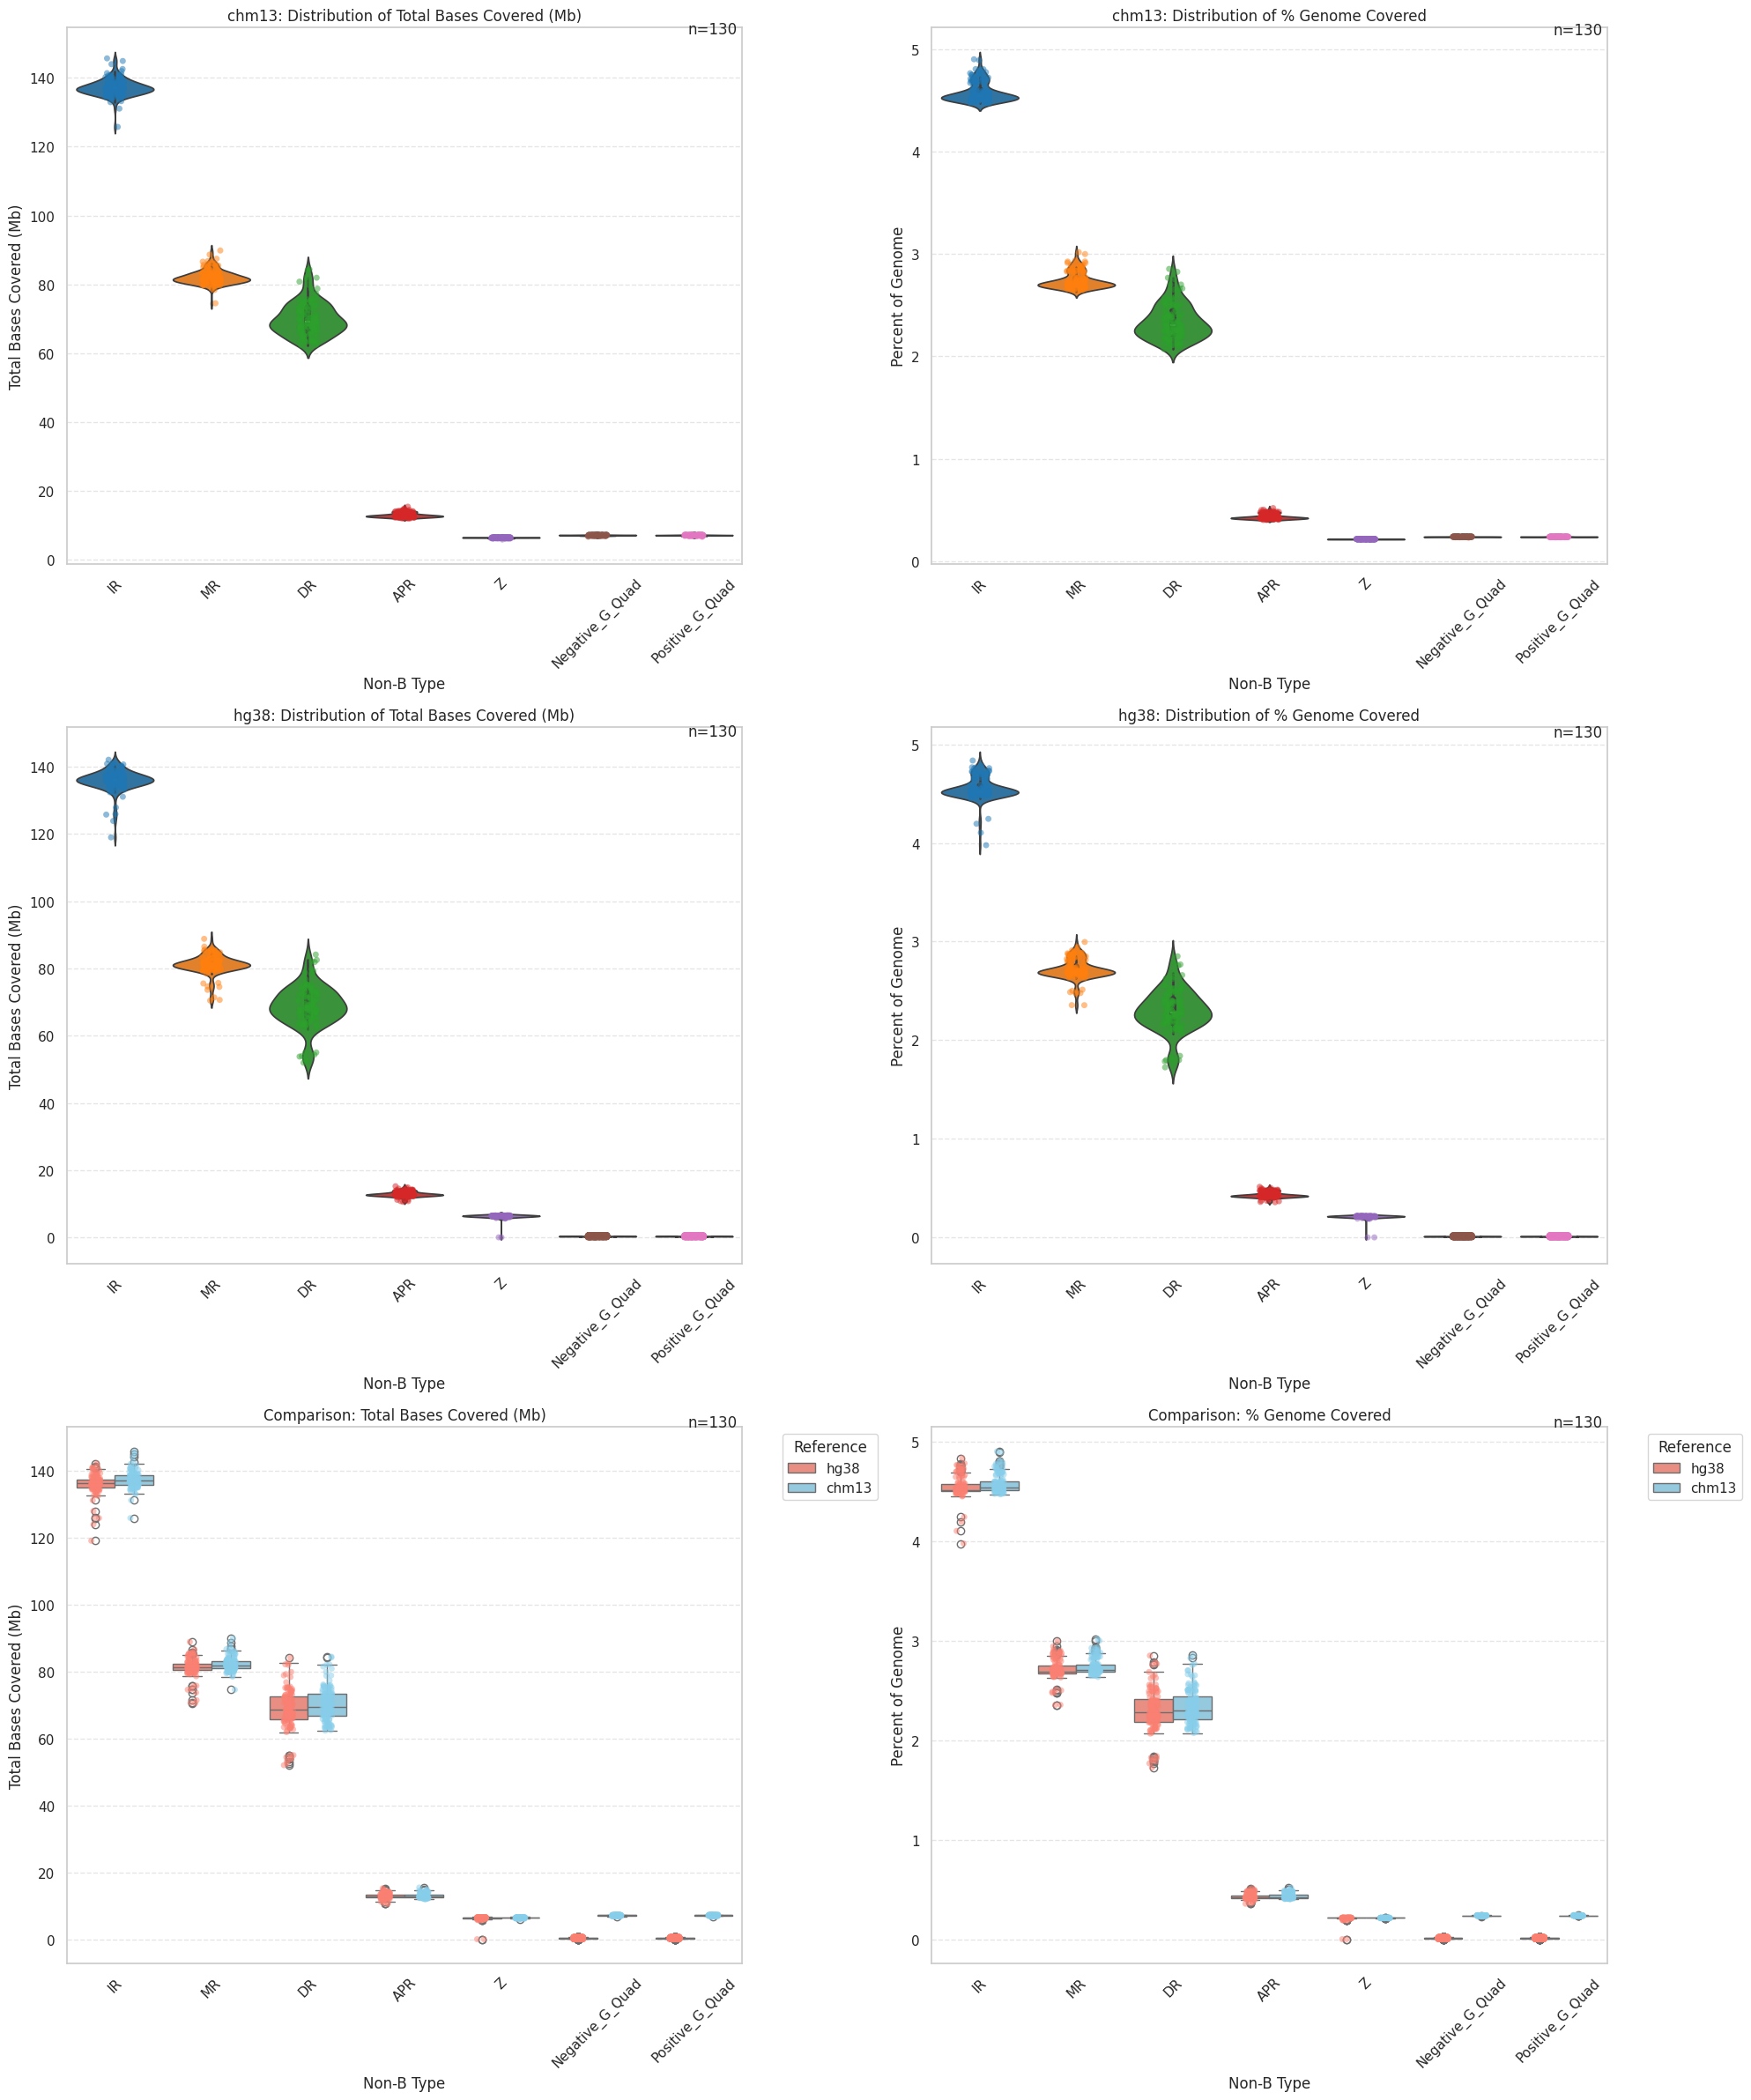

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load and process batches
def load_and_process_batches(chm13_paths, hg38_paths):
    def process(paths, reference, extra_path=None):
        dfs = [pd.read_csv(p) for p in paths]
        df = pd.concat(dfs, ignore_index=True)
        df[['Sample', 'Haplotype']] = df['Sample_Haplotype'].str.split('_', expand=True)
        df = df[df['Sample_Haplotype'] != 'NA20355_hap1']
        df['Total Bases Covered (Mb)'] = df['Total Bases Covered'] / 1e6
        df['Reference'] = reference
        if extra_path:
            extra = pd.read_csv(extra_path)
            extra[['Sample', 'Haplotype']] = extra['Sample_Haplotype'].str.split('_', expand=True)
            extra['Total Bases Covered (Mb)'] = extra['Total Bases Covered'] / 1e6
            extra['Reference'] = reference
            df = pd.concat([df, extra], ignore_index=True)
        return df

    chm13 = process(chm13_paths, 'chm13', '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv')
    hg38 = process(hg38_paths, 'hg38', '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch123_hg38_collapsed_quadron_summary_metrics_combined_chr.csv')
    return chm13, hg38

# Define paths
chm13_paths = [
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch1_chm13_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch2_chm13_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch3_chm13_collapsed_summary_metrics.csv']

hg38_paths = [
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch1_hg38_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch2_hg38_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch3_hg38_collapsed_summary_metrics.csv']

chm13_df, hg38_df = load_and_process_batches(chm13_paths, hg38_paths)
combined_df = pd.concat([chm13_df, hg38_df], ignore_index=True).sort_values('Sample_Haplotype')

# Load metadata
meta = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/igsr_samples.tsv', sep='\t')
meta_cols = ['Sample name', 'Sex', 'Superpopulation name', 'Superpopulation code']

merged_chm13 = pd.merge(chm13_df, meta[meta_cols], left_on='Sample', right_on='Sample name', how='left')
merged_hg38 = pd.merge(hg38_df, meta[meta_cols], left_on='Sample', right_on='Sample name', how='left')
merged_df = pd.concat([merged_chm13, merged_hg38], ignore_index=True)

unique_haps = merged_df['Sample_Haplotype'].nunique()
reference_palette = {'chm13': 'skyblue', 'hg38': 'salmon'}

# Order motif types
motif_order = combined_df.groupby('Motif Type')['Total Bases Covered (Mb)'].median().sort_values(ascending=False).index.tolist()
for df in [combined_df, merged_chm13, merged_hg38]:
    df['Motif Type'] = pd.Categorical(df['Motif Type'], categories=motif_order, ordered=True)

# Plot
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
plot_info = [
    (merged_chm13, 'Total Bases Covered (Mb)', 'chm13: Distribution of Total Bases Covered (Mb)', axes[0,0]),
    (merged_chm13, 'Percent of Genome', 'chm13: Distribution of % Genome Covered', axes[0,1]),
    (merged_hg38, 'Total Bases Covered (Mb)', 'hg38: Distribution of Total Bases Covered (Mb)', axes[1,0]),
    (merged_hg38, 'Percent of Genome', 'hg38: Distribution of % Genome Covered', axes[1,1]),
    (combined_df, 'Total Bases Covered (Mb)', 'Comparison: Total Bases Covered (Mb)', axes[2,0]),
    (combined_df, 'Percent of Genome', 'Comparison: % Genome Covered', axes[2,1])
]

for df, y, title, ax in plot_info:
    kind = 'box' if 'Comparison' in title else 'violin'
    if kind == 'box':
        sns.boxplot(data=df, x='Motif Type', y=y, hue='Reference', palette=reference_palette, order=motif_order, ax=ax)
    else:
        sns.violinplot(data=df, x='Motif Type', y=y, hue='Motif Type', palette='tab10', dodge=False, order=motif_order, legend=False, ax=ax)
    sns.stripplot(data=df, x='Motif Type', y=y, hue='Reference' if 'Comparison' in title else 'Motif Type',
                  palette=reference_palette if 'Comparison' in title else 'tab10', alpha=0.5, dodge='Comparison' in title,
                  jitter=True, order=motif_order, legend=False, ax=ax)
    ax.set_xlabel('Non-B Type')
    ax.set_ylabel(y)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)
    if 'Comparison' in title:
        ax.legend(title='Reference', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend_.remove() if ax.legend_ else None
    ax.text(x=len(motif_order)-0.55, y=df[y].max()*1.05, s=f"n={df['Sample_Haplotype'].nunique()}", fontsize=12, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/chm13_hg38_verkko_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_910883/2491703401.py:87: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(
/tmp/ipykernel_910883/2491703401.py:87: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


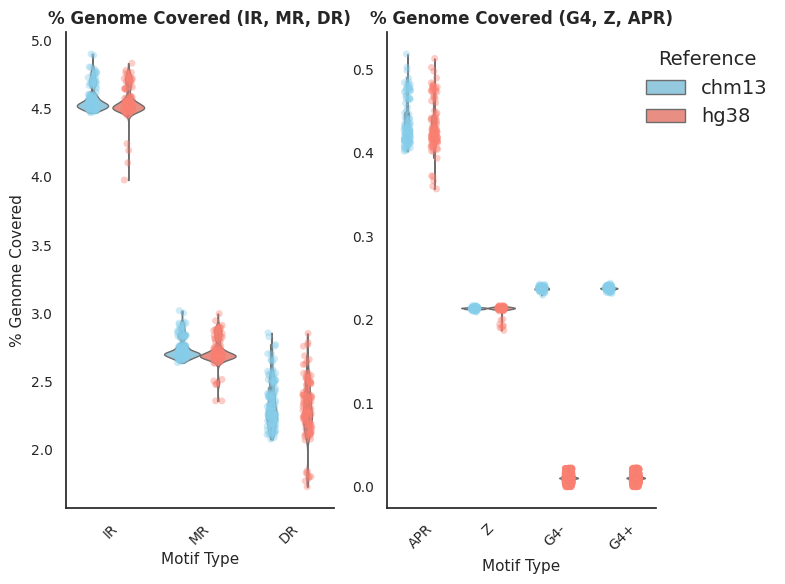

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

sns.set(style="white")

# === Load and process batches ===
def load_and_process_batches(chm13_paths, hg38_paths):
    def process(paths, reference, extra_path=None):
        dfs = [pd.read_csv(p) for p in paths]
        df = pd.concat(dfs, ignore_index=True)
        df[['Sample', 'Haplotype']] = df['Sample_Haplotype'].str.split('_', expand=True)
        df = df[df['Sample_Haplotype'] != 'NA20355_hap1']
        df['Total Bases Covered (Mb)'] = df['Total Bases Covered'] / 1e6
        df['Reference'] = reference
        if extra_path:
            extra = pd.read_csv(extra_path)
            extra[['Sample', 'Haplotype']] = extra['Sample_Haplotype'].str.split('_', expand=True)
            extra['Total Bases Covered (Mb)'] = extra['Total Bases Covered'] / 1e6
            extra['Reference'] = reference
            df = pd.concat([df, extra], ignore_index=True)
        return df

    chm13 = process(chm13_paths, 'chm13', '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv')
    hg38 = process(hg38_paths, 'hg38', '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch123_hg38_collapsed_quadron_summary_metrics_combined_chr.csv')
    return chm13, hg38

# === Define input paths ===
chm13_paths = [
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch1_chm13_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch2_chm13_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch3_chm13_collapsed_summary_metrics.csv'
]

hg38_paths = [
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch1_hg38_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch2_hg38_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch3_hg38_collapsed_summary_metrics.csv'
]

# === Load and merge
chm13_df, hg38_df = load_and_process_batches(chm13_paths, hg38_paths)
combined_df = pd.concat([chm13_df, hg38_df], ignore_index=True)

# Remove Z-DNA rows with 0 coverage
combined_df = combined_df[~((combined_df['Motif Type'] == 'Z') & (combined_df['Percent of Genome'] == 0))]

# Rename G4 types
combined_df['Motif Type'] = combined_df['Motif Type'].replace({
    'Positive_G_Quad': 'G4+',
    'Negative_G_Quad': 'G4-'
})

# === Clean categories
reference_palette = {'chm13': 'skyblue', 'hg38': 'salmon'}
group1_motifs = ['IR', 'MR', 'DR']
group2_motifs = sorted(set(combined_df['Motif Type']) - set(group1_motifs))

# Assign group column
combined_df['Group'] = combined_df['Motif Type'].apply(lambda x: 'IR/MR/DR' if x in group1_motifs else 'Other')

# Determine plotting order
group1_df = combined_df[combined_df['Group'] == 'IR/MR/DR']
group2_df = combined_df[combined_df['Group'] == 'Other']
group1_order = group1_df.groupby('Motif Type')['Percent of Genome'].median().sort_values(ascending=False).index.tolist()
group2_order = group2_df.groupby('Motif Type')['Percent of Genome'].median().sort_values(ascending=False).index.tolist()

# Apply ordered category
combined_df['Motif Type'] = pd.Categorical(
    combined_df['Motif Type'],
    categories=group1_order + group2_order,
    ordered=True
)

# === Final Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=False)

for ax, group_label, motif_order, title in zip(
    axes,
    ['IR/MR/DR', 'Other'],
    [group1_order, group2_order],
    ['% Genome Covered (IR, MR, DR)', '% Genome Covered (G4, Z, APR)']
):
    group_df = combined_df[combined_df['Group'] == group_label]

    sns.violinplot(
        data=group_df,
        x='Motif Type',
        y='Percent of Genome',
        hue='Reference',
        palette=reference_palette,
        order=motif_order,
        dodge=True,
        cut=0,
        bw=0.2,
        ax=ax,
        linewidth=1
    )
    sns.stripplot(
        data=group_df,
        x='Motif Type',
        y='Percent of Genome',
        hue='Reference',
        palette=reference_palette,
        order=motif_order,
        dodge=True,
        jitter=True,
        alpha=0.4,
        ax=ax,
        legend=False
    )

    ax.set_xlabel('Motif Type', fontsize=11)
    ax.set_ylabel('% Genome Covered' if ax == axes[0] else '', fontsize=11)
    ax.set_title(title, fontsize=12, weight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(False)
    sns.despine(ax=ax)

    if ax == axes[1]:
        ax.legend(
        title='Reference',
        loc='upper left',
        bbox_to_anchor=(0.9, 1),    # move left (try 0.8–0.9 range)
        fontsize=14,                 # increase text size
        title_fontsize=14,           # increase title size
        frameon=False                # optional: remove box
    )
    else:
        ax.get_legend().remove()

plt.tight_layout()
plt.savefig("/home/alextu/projects/def-sushant/alextu/side_by_side_violin_split.pdf", dpi=300)
plt.show()

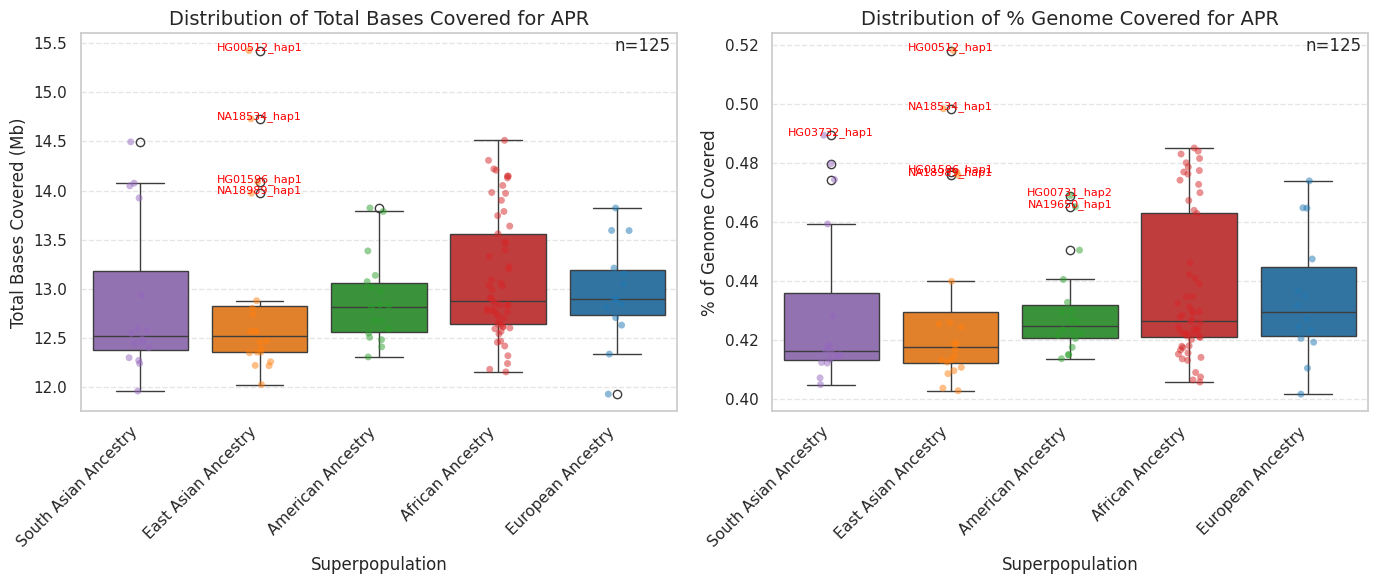

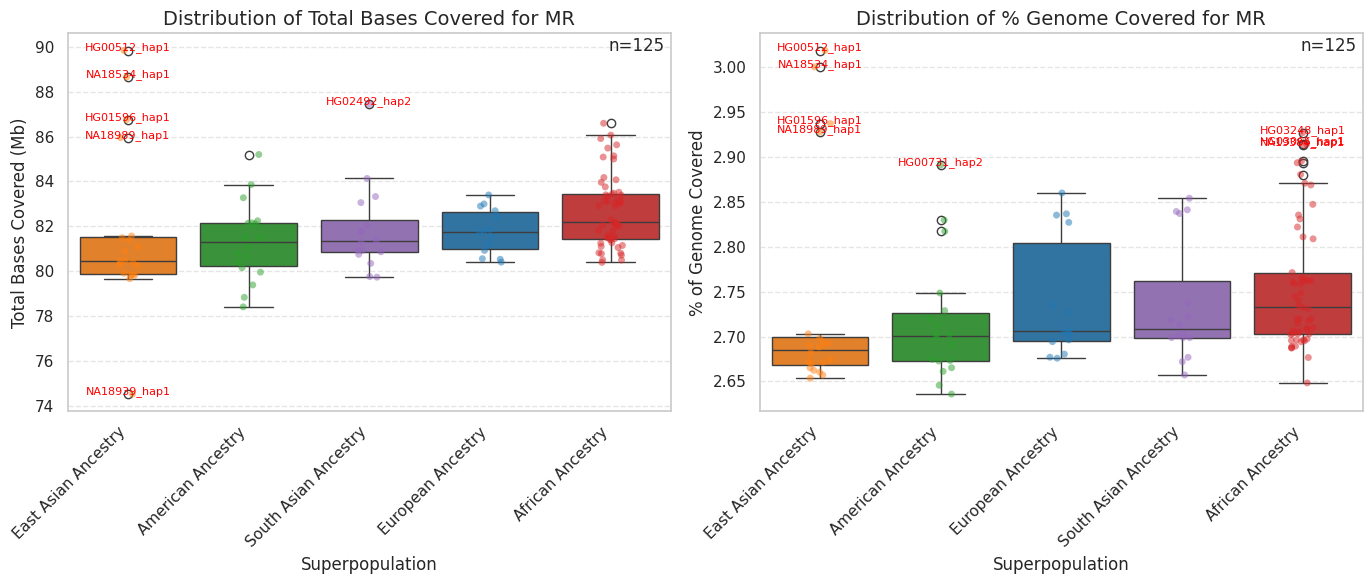

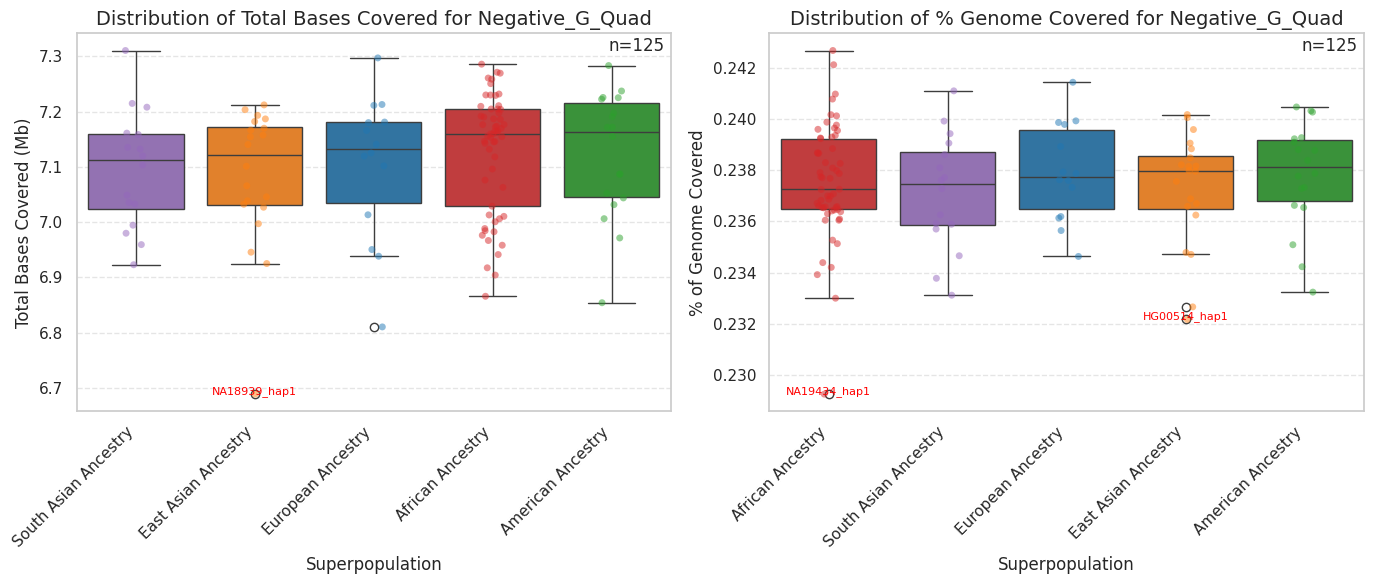

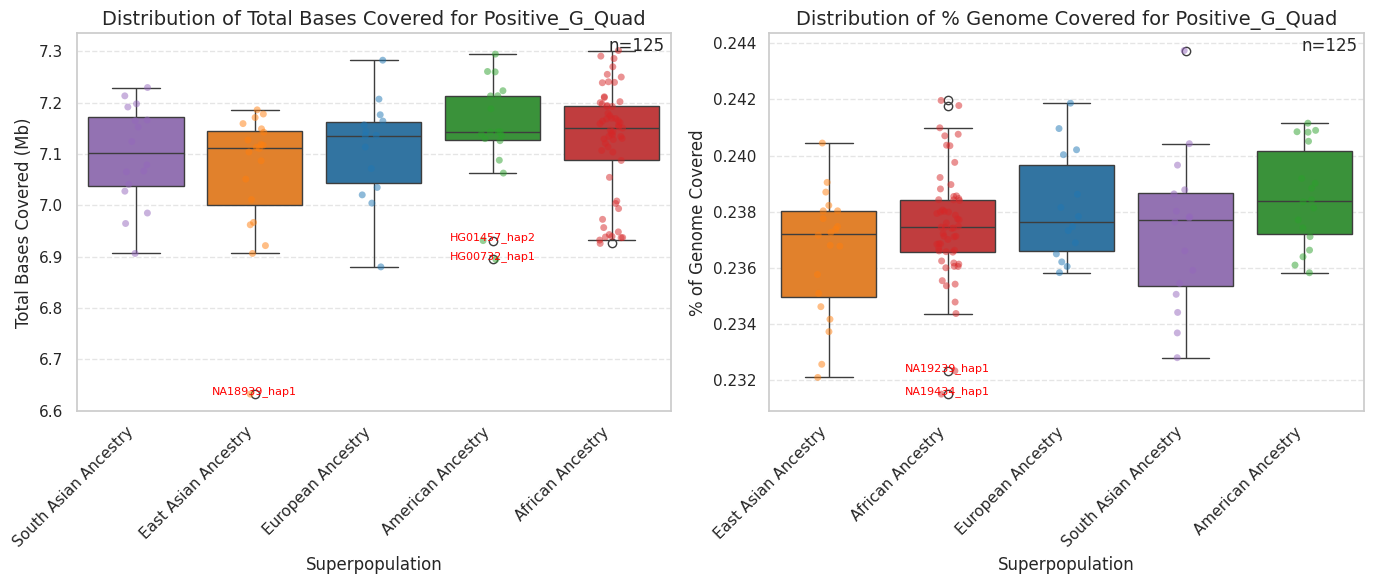

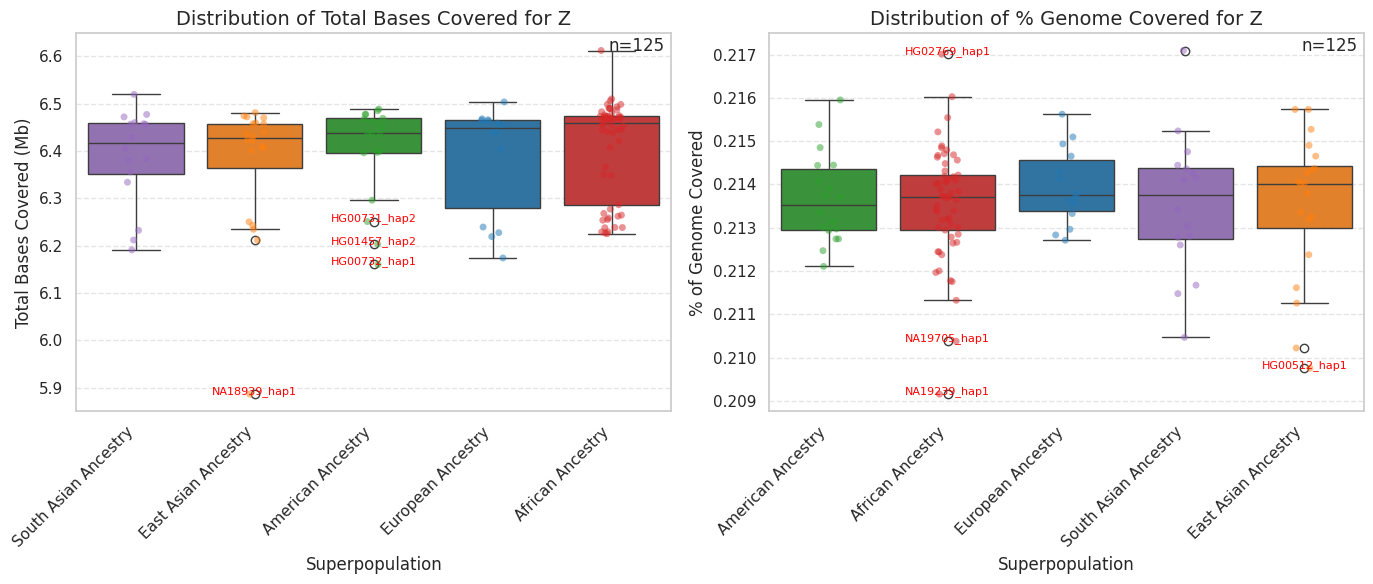

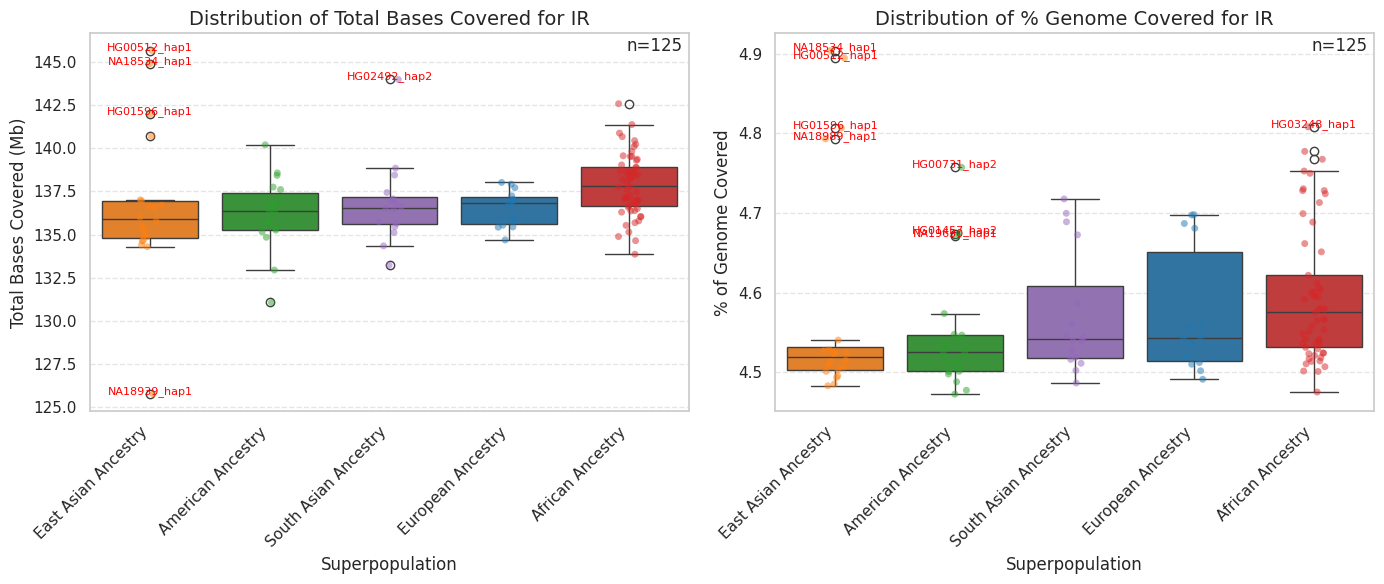

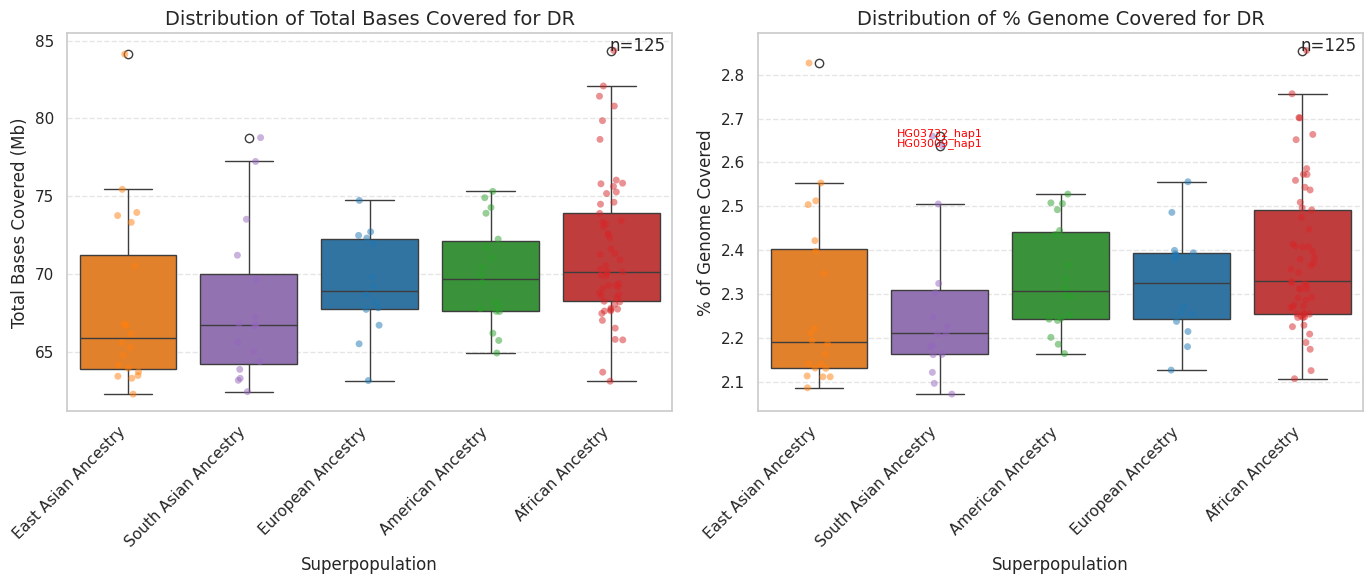

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your feature counts dataframes
batch1 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch1_chm13_collapsed_summary_metrics.csv')
batch2 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch2_chm13_collapsed_summary_metrics.csv')
batch3 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch3_chm13_collapsed_summary_metrics.csv')
batch4 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv')

# Combine the dataframes
df = pd.concat([batch1, batch2, batch3, batch4], ignore_index=True)

# Extract sample identifier (e.g., HG#### or NA####) and haplotype from 'Sample_Haplotype' column
df[['Sample', 'Haplotype']] = df['Sample_Haplotype'].str.split('_', expand=True)

# Remove the specified sample_haplotype
df = df[df['Sample_Haplotype'] != 'NA20355_hap1']

# Sort by 'Sample_Haplotype'
sorted_df = df.sort_values(by='Sample_Haplotype')

# Assuming the metadata file is already read into metadata_df
metadata_df = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/igsr_samples.tsv', delimiter='\t')

# Merge metadata with the sorted DataFrame on 'Sample' column
merged_df = pd.merge(sorted_df, metadata_df[['Sample name', 'Sex', 'Superpopulation name', 'Superpopulation code']], left_on='Sample', right_on='Sample name', how='left')

# Convert 'Total Bases Covered' to Megabases
merged_df['Total Bases Covered (Mb)'] = merged_df['Total Bases Covered'] / 1_000_000

# Function to identify outliers
def identify_outliers(data, multiplier=2):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# Define a color palette
superpopulations = merged_df['Superpopulation name'].unique()
palette = sns.color_palette("tab10", len(superpopulations))
color_dict = dict(zip(superpopulations, palette))

# Plotting using seaborn
motif_types = merged_df['Motif Type'].unique()

for motif in motif_types:
    motif_df = merged_df[merged_df['Motif Type'] == motif]
    
    # Calculate medians for sorting
    medians_total_bases = motif_df.groupby('Superpopulation name')['Total Bases Covered (Mb)'].median().sort_values()
    medians_percent_genome = motif_df.groupby('Superpopulation name')['Percent of Genome'].median().sort_values()

    # Sort data by increasing median
    sorted_motif_df_total_bases = motif_df.set_index('Superpopulation name').loc[medians_total_bases.index].reset_index()
    sorted_motif_df_percent_genome = motif_df.set_index('Superpopulation name').loc[medians_percent_genome.index].reset_index()
    
    plt.figure(figsize=(14, 6))  # Adjust the figure size as needed

    # First subplot with distribution of total bases covered in Megabases
    plt.subplot(1, 2, 1)
    # Create a boxplot using seaborn
    sns.boxplot(data=sorted_motif_df_total_bases, x='Superpopulation name', y='Total Bases Covered (Mb)', hue='Superpopulation name', palette=color_dict, dodge=False)
    # Add jittered strip plot
    sns.stripplot(data=sorted_motif_df_total_bases, x='Superpopulation name', y='Total Bases Covered (Mb)', hue='Superpopulation name', palette=color_dict, alpha=0.5, dodge=False, jitter=True, legend=False)
    
    # Identify and annotate outliers
    for pop in sorted_motif_df_total_bases['Superpopulation name'].unique():
        pop_data = sorted_motif_df_total_bases[sorted_motif_df_total_bases['Superpopulation name'] == pop]
        outliers = identify_outliers(pop_data['Total Bases Covered (Mb)'])
        for i in outliers.index:
            sample_haplotype = f"{sorted_motif_df_total_bases.loc[i, 'Sample']}_{sorted_motif_df_total_bases.loc[i, 'Haplotype']}"
            plt.text(x=list(sorted_motif_df_total_bases['Superpopulation name'].unique()).index(pop), y=outliers[i], s=sample_haplotype, color='red', fontsize=8, ha='center')
    
    # Add total number of unique sample_haplotypes plotted to the top right
    n_haplotypes = sorted_motif_df_total_bases['Sample_Haplotype'].nunique()
    plt.text(x=sorted_motif_df_total_bases['Superpopulation name'].nunique() - 0.55, y=sorted_motif_df_total_bases['Total Bases Covered (Mb)'].max() * 1.0, s=f"n={n_haplotypes}", fontsize=12, ha='right')

    # Customize plot
    plt.xlabel('Superpopulation', fontsize=12)
    plt.ylabel('Total Bases Covered (Mb)', fontsize=12)
    plt.title(f'Distribution of Total Bases Covered for {motif}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend([],[], frameon=False)  # Remove legend from the subplot

    # Second subplot with distribution of percent genome covered
    plt.subplot(1, 2, 2)
    # Create a boxplot using seaborn
    sns.boxplot(data=sorted_motif_df_percent_genome, x='Superpopulation name', y='Percent of Genome', hue='Superpopulation name', palette=color_dict, dodge=False)
    # Add jittered strip plot
    sns.stripplot(data=sorted_motif_df_percent_genome, x='Superpopulation name', y='Percent of Genome', hue='Superpopulation name', palette=color_dict, alpha=0.5, dodge=False, jitter=True, legend=False)
    
    # Identify and annotate outliers
    for pop in sorted_motif_df_percent_genome['Superpopulation name'].unique():
        pop_data = sorted_motif_df_percent_genome[sorted_motif_df_percent_genome['Superpopulation name'] == pop]
        outliers = identify_outliers(pop_data['Percent of Genome'])
        for i in outliers.index:
            sample_haplotype = f"{sorted_motif_df_percent_genome.loc[i, 'Sample']}_{sorted_motif_df_percent_genome.loc[i, 'Haplotype']}"
            plt.text(x=list(sorted_motif_df_percent_genome['Superpopulation name'].unique()).index(pop), y=outliers[i], s=sample_haplotype, color='red', fontsize=8, ha='center')
    
    # Add total number of unique sample_haplotypes plotted to the top right
    n_haplotypes = sorted_motif_df_percent_genome['Sample_Haplotype'].nunique()
    plt.text(x=sorted_motif_df_percent_genome['Superpopulation name'].nunique() - 0.55, y=sorted_motif_df_percent_genome['Percent of Genome'].max() * 1.0, s=f"n={n_haplotypes}", fontsize=12, ha='right')

    # Customize plot
    plt.xlabel('Superpopulation', fontsize=12)
    plt.ylabel('% of Genome Covered', fontsize=12)
    plt.title(f'Distribution of % Genome Covered for {motif}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend([],[], frameon=False)  # Remove legend from the subplot

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


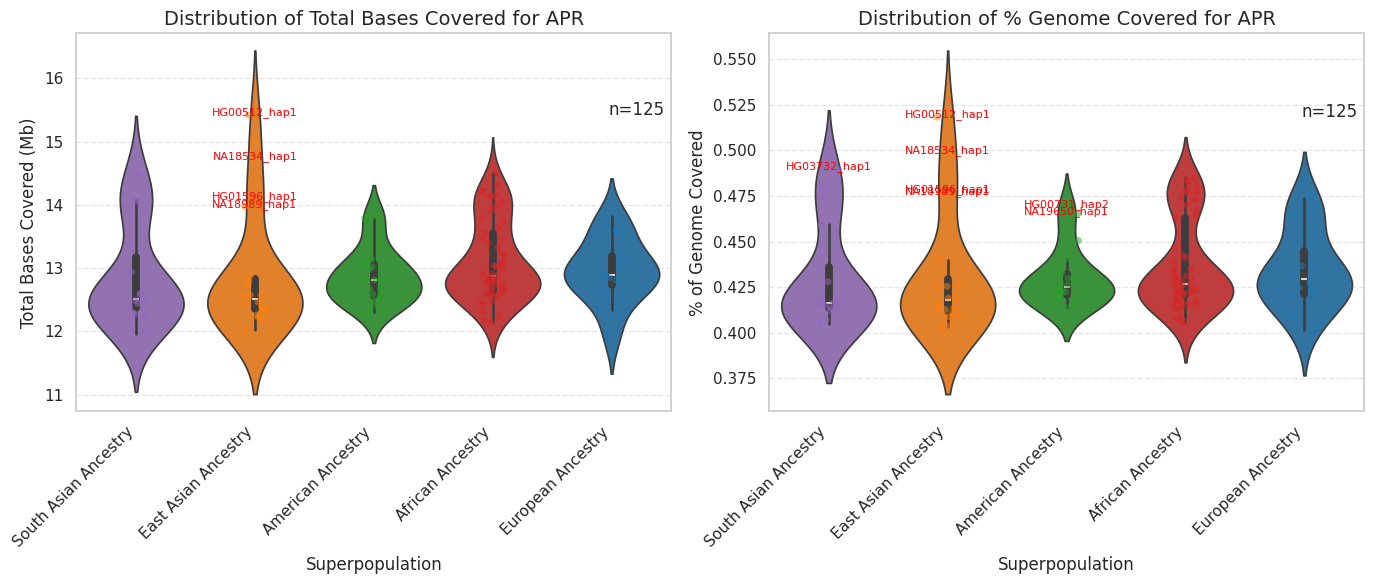

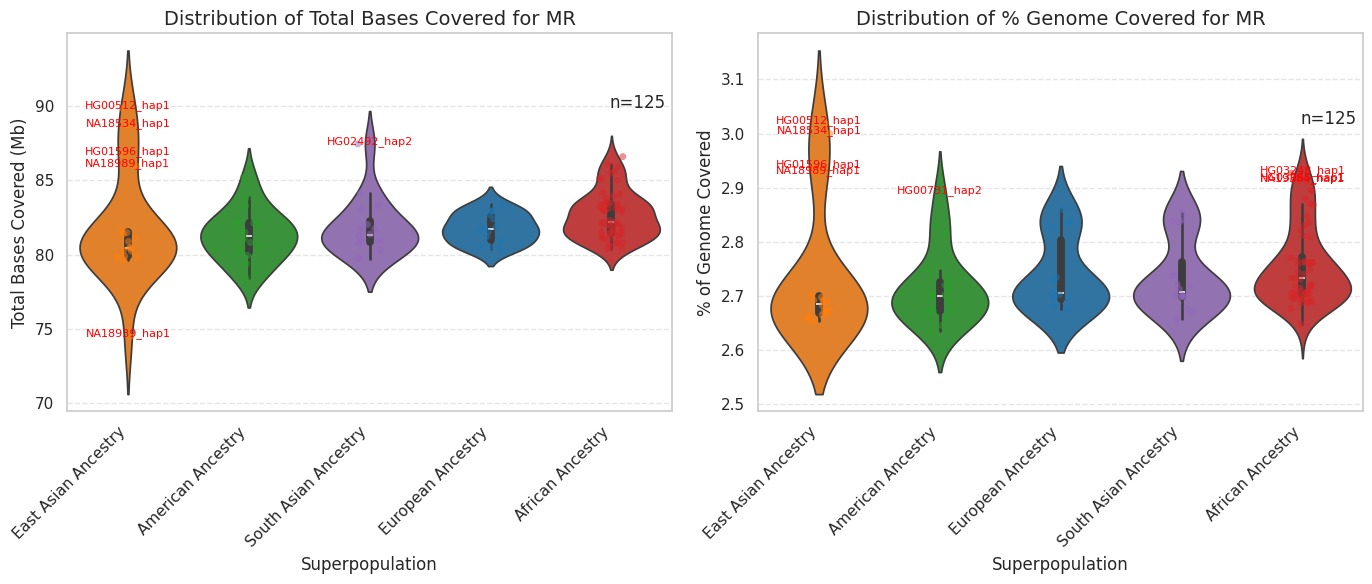

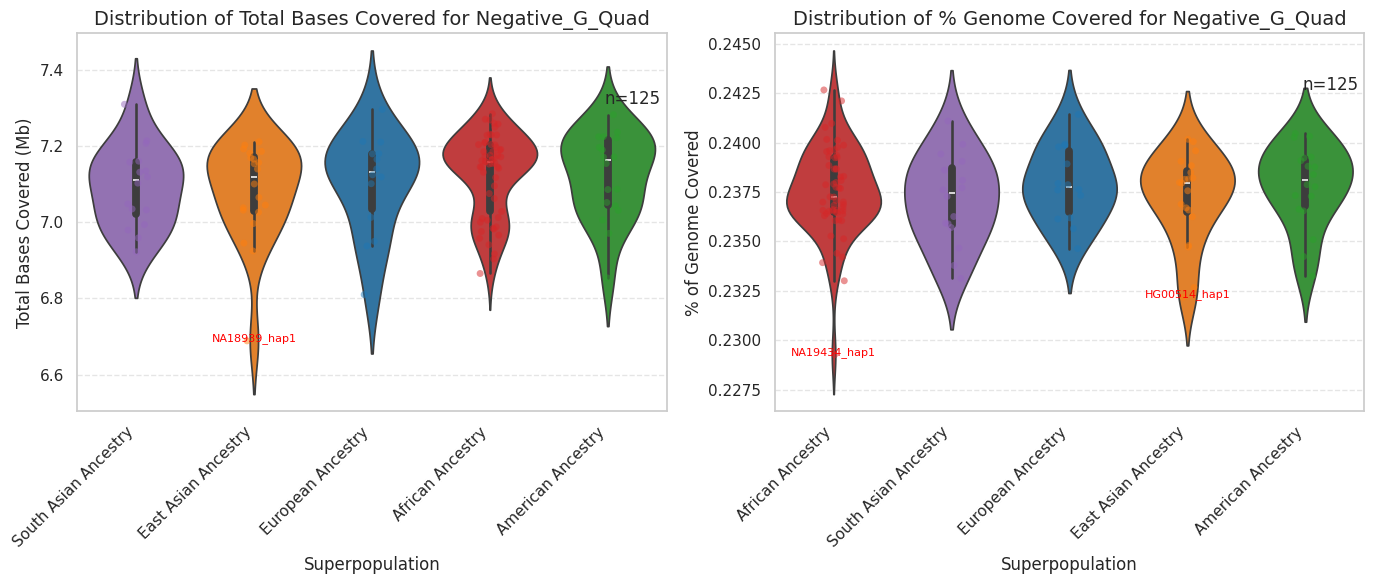

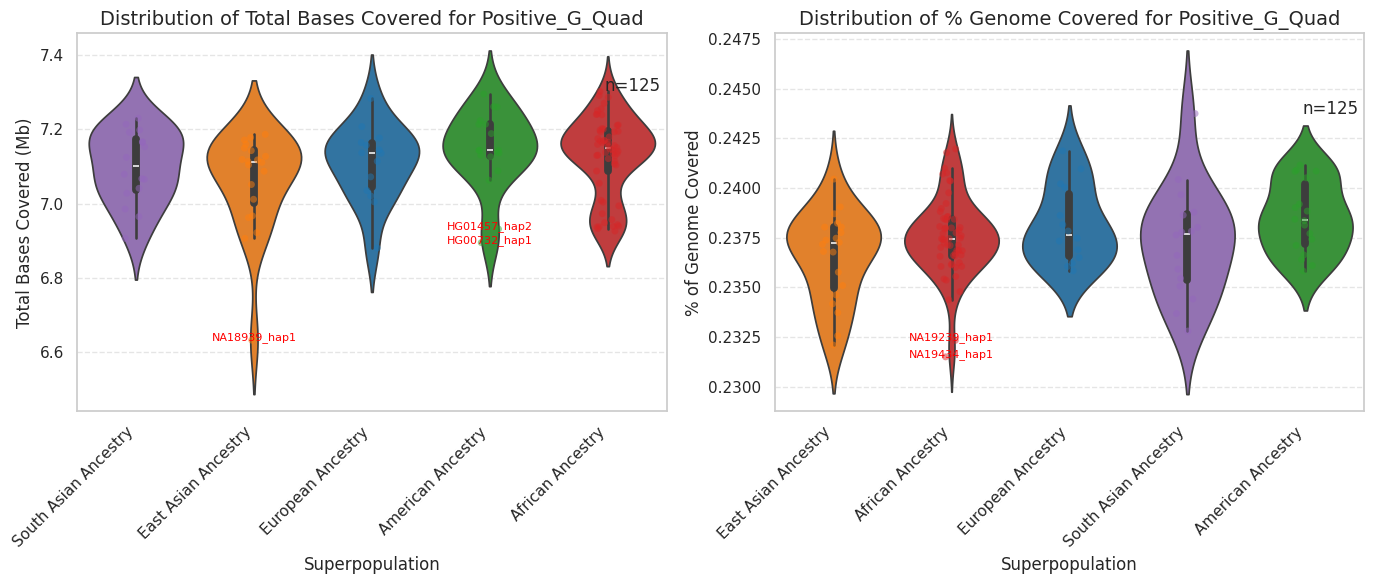

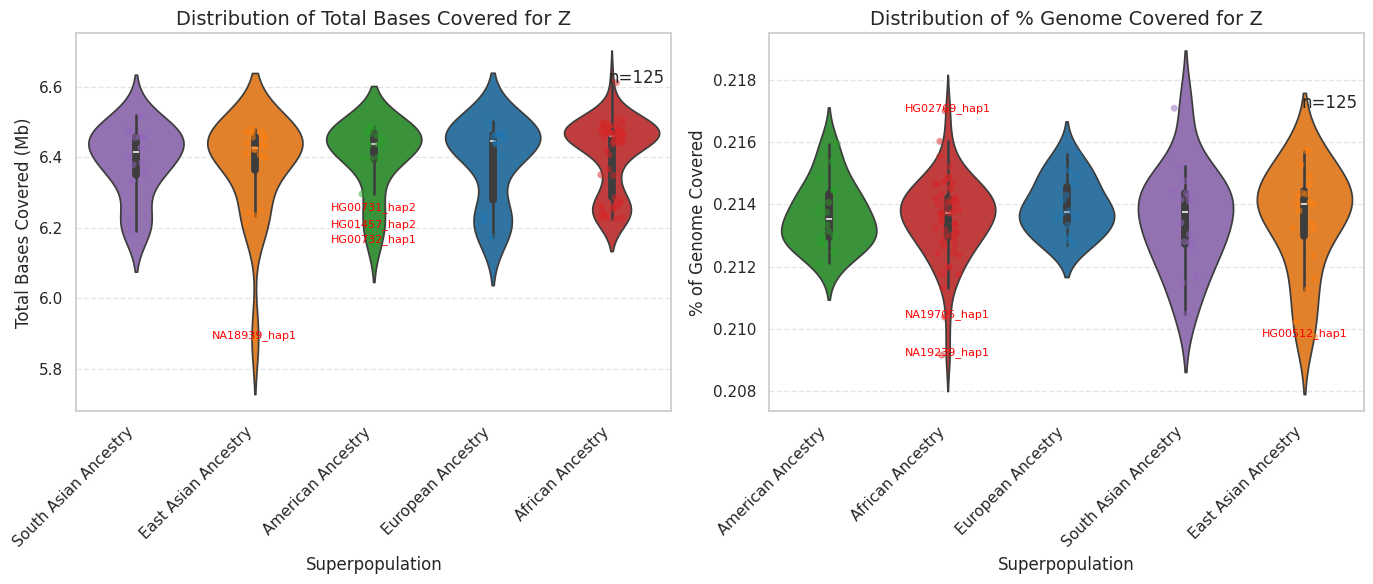

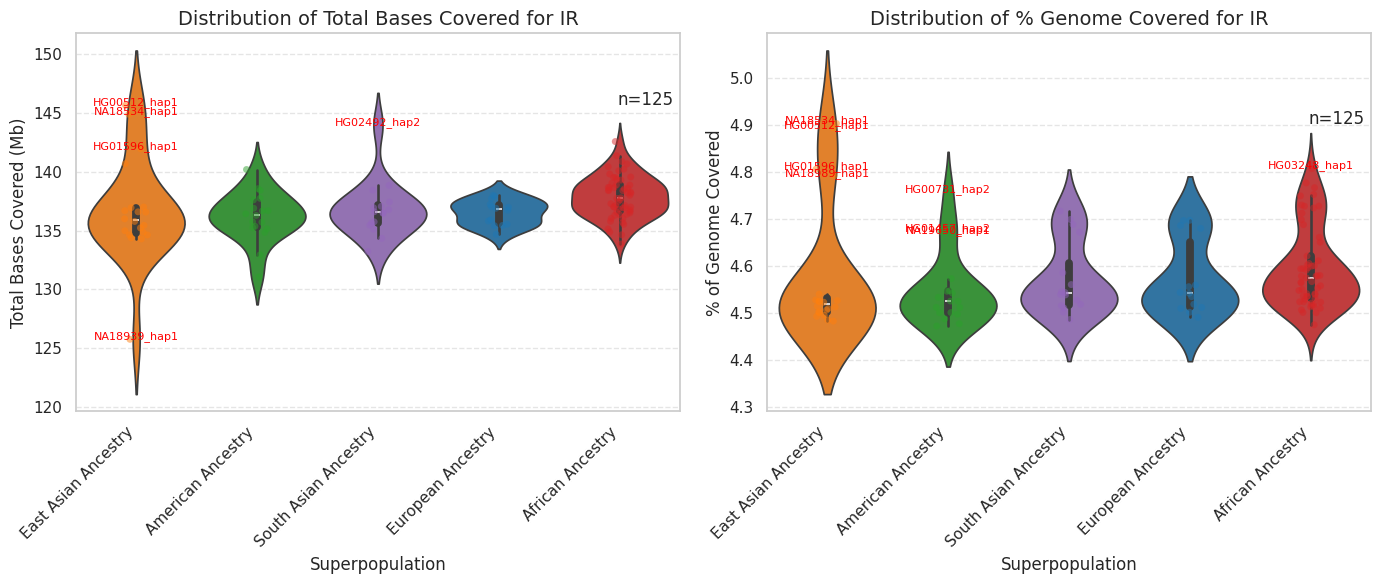

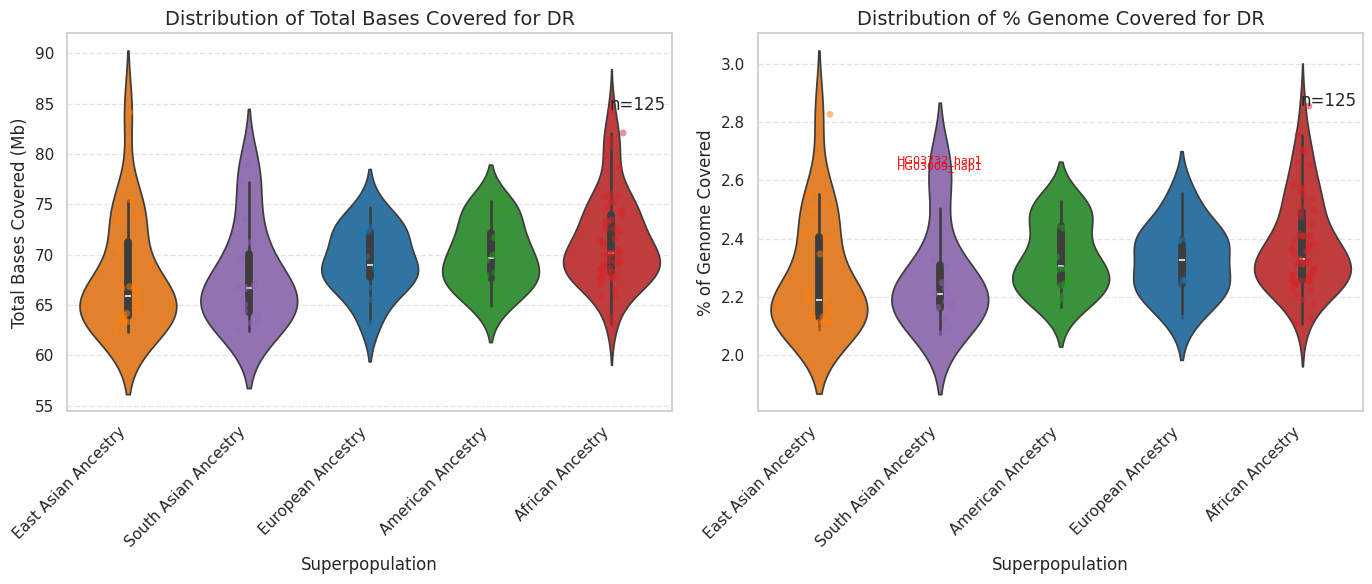

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your feature counts dataframes
batch1 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch1_chm13_collapsed_summary_metrics.csv')
batch2 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch2_chm13_collapsed_summary_metrics.csv')
batch3 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch3_chm13_collapsed_summary_metrics.csv')
batch4 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv')

# Combine the dataframes
df = pd.concat([batch1, batch2, batch3, batch4], ignore_index=True)

# Extract sample identifier (e.g., HG#### or NA####) and haplotype from 'Sample_Haplotype' column
df[['Sample', 'Haplotype']] = df['Sample_Haplotype'].str.split('_', expand=True)

# Remove the specified sample_haplotype
df = df[df['Sample_Haplotype'] != 'NA20355_hap1']

# Sort by 'Sample_Haplotype'
sorted_df = df.sort_values(by='Sample_Haplotype')

# Assuming the metadata file is already read into metadata_df
metadata_df = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/igsr_samples.tsv', delimiter='\t')

# Merge metadata with the sorted DataFrame on 'Sample' column
merged_df = pd.merge(sorted_df, metadata_df[['Sample name', 'Sex', 'Superpopulation name', 'Superpopulation code']], left_on='Sample', right_on='Sample name', how='left')

# Convert 'Total Bases Covered' to Megabases
merged_df['Total Bases Covered (Mb)'] = merged_df['Total Bases Covered'] / 1_000_000

# Function to identify outliers
def identify_outliers(data, multiplier=2):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# Define a color palette
superpopulations = merged_df['Superpopulation name'].unique()
palette = sns.color_palette("tab10", len(superpopulations))
color_dict = dict(zip(superpopulations, palette))

# Plotting using seaborn
motif_types = merged_df['Motif Type'].unique()

for motif in motif_types:
    motif_df = merged_df[merged_df['Motif Type'] == motif]
    
    # Calculate medians for sorting
    medians_total_bases = motif_df.groupby('Superpopulation name')['Total Bases Covered (Mb)'].median().sort_values()
    medians_percent_genome = motif_df.groupby('Superpopulation name')['Percent of Genome'].median().sort_values()

    # Sort data by increasing median
    sorted_motif_df_total_bases = motif_df.set_index('Superpopulation name').loc[medians_total_bases.index].reset_index()
    sorted_motif_df_percent_genome = motif_df.set_index('Superpopulation name').loc[medians_percent_genome.index].reset_index()
    
    plt.figure(figsize=(14, 6))  # Adjust the figure size as needed

    # First subplot with distribution of total bases covered in Megabases
    plt.subplot(1, 2, 1)
    # Create a violin plot using seaborn
    sns.violinplot(data=sorted_motif_df_total_bases, x='Superpopulation name', y='Total Bases Covered (Mb)', hue='Superpopulation name', palette=color_dict, dodge=False)
    # Add jittered strip plot
    sns.stripplot(data=sorted_motif_df_total_bases, x='Superpopulation name', y='Total Bases Covered (Mb)', hue='Superpopulation name', palette=color_dict, alpha=0.5, dodge=False, jitter=True, legend=False)
    
    # Identify and annotate outliers
    for pop in sorted_motif_df_total_bases['Superpopulation name'].unique():
        pop_data = sorted_motif_df_total_bases[sorted_motif_df_total_bases['Superpopulation name'] == pop]
        outliers = identify_outliers(pop_data['Total Bases Covered (Mb)'])
        for i in outliers.index:
            sample_haplotype = f"{sorted_motif_df_total_bases.loc[i, 'Sample']}_{sorted_motif_df_total_bases.loc[i, 'Haplotype']}"
            plt.text(x=list(sorted_motif_df_total_bases['Superpopulation name'].unique()).index(pop), y=outliers[i], s=sample_haplotype, color='red', fontsize=8, ha='center')
    
    # Add total number of unique sample_haplotypes plotted to the top right
    n_haplotypes = sorted_motif_df_total_bases['Sample_Haplotype'].nunique()
    plt.text(x=sorted_motif_df_total_bases['Superpopulation name'].nunique() - 0.55, y=sorted_motif_df_total_bases['Total Bases Covered (Mb)'].max() * 1.0, s=f"n={n_haplotypes}", fontsize=12, ha='right')

    # Customize plot
    plt.xlabel('Superpopulation', fontsize=12)
    plt.ylabel('Total Bases Covered (Mb)', fontsize=12)
    plt.title(f'Distribution of Total Bases Covered for {motif}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend([],[], frameon=False)  # Remove legend from the subplot

    # Second subplot with distribution of percent genome covered
    plt.subplot(1, 2, 2)
    # Create a violin plot using seaborn
    sns.violinplot(data=sorted_motif_df_percent_genome, x='Superpopulation name', y='Percent of Genome', hue='Superpopulation name', palette=color_dict, dodge=False)
    # Add jittered strip plot
    sns.stripplot(data=sorted_motif_df_percent_genome, x='Superpopulation name', y='Percent of Genome', hue='Superpopulation name', palette=color_dict, alpha=0.5, dodge=False, jitter=True, legend=False)
    
    # Identify and annotate outliers
    for pop in sorted_motif_df_percent_genome['Superpopulation name'].unique():
        pop_data = sorted_motif_df_percent_genome[sorted_motif_df_percent_genome['Superpopulation name'] == pop]
        outliers = identify_outliers(pop_data['Percent of Genome'])
        for i in outliers.index:
            sample_haplotype = f"{sorted_motif_df_percent_genome.loc[i, 'Sample']}_{sorted_motif_df_percent_genome.loc[i, 'Haplotype']}"
            plt.text(x=list(sorted_motif_df_percent_genome['Superpopulation name'].unique()).index(pop), y=outliers[i], s=sample_haplotype, color='red', fontsize=8, ha='center')
    
    # Add total number of unique sample_haplotypes plotted to the top right
    n_haplotypes = sorted_motif_df_percent_genome['Sample_Haplotype'].nunique()
    plt.text(x=sorted_motif_df_percent_genome['Superpopulation name'].nunique() - 0.55, y=sorted_motif_df_percent_genome['Percent of Genome'].max() * 1.0, s=f"n={n_haplotypes}", fontsize=12, ha='right')

    # Customize plot
    plt.xlabel('Superpopulation', fontsize=12)
    plt.ylabel('% of Genome Covered', fontsize=12)
    plt.title(f'Distribution of % Genome Covered for {motif}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend([],[], frameon=False)  # Remove legend from the subplot

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


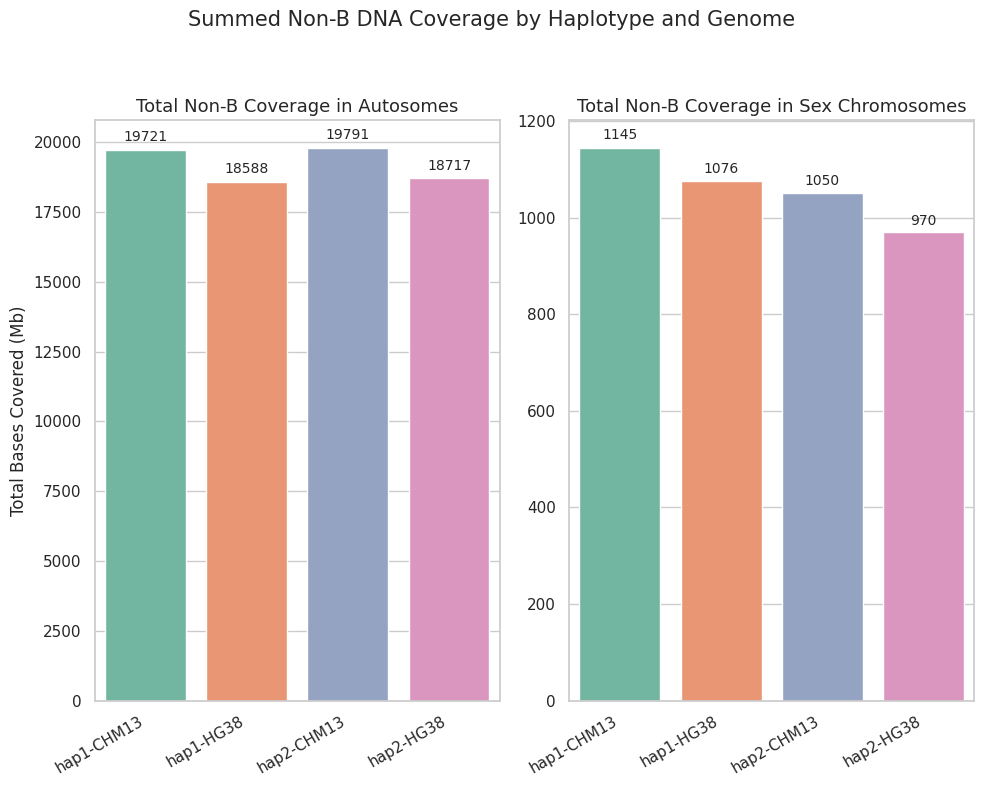

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# =========================================================
# Part 1: Load and Prepare Data
# =========================================================

def load_data(batches, reference):
    dfs = []
    for batch in batches:
        file_path = f'/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/{reference}_Q19_filtered/verkko_batch{batch}_{reference}_collapsed_summary_metrics_chr.csv'
        df = pd.read_csv(file_path)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def prepare_coverage_data(data):
    data = data.copy()
    split_cols = data['Sample_Haplotype_Chromosome'].str.split('|', expand=True)
    data['Sample_Haplotype'] = split_cols[0]
    data['Chromosome'] = split_cols[2]
    data['Haplotype'] = data['Sample_Haplotype'].str.extract(r'(hap\d)')[0]
    return data

def load_quad_data(reference):
    quad_path = f'/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/{reference}_Q19_filtered/verkko_batch123_{reference}_collapsed_quadron_summary_metrics_combined_chr.csv'
    quad_df = pd.read_csv(quad_path)
    quad_df['Label'] = reference.upper()
    return quad_df

def prepare_quad_data(data):
    data = data.copy()
    data['Haplotype'] = data['Sample_Haplotype'].str.extract(r'(hap\d)')[0]
    return data

# === Load & prepare ===
batches = [1, 2, 3]
hg38_data = load_data(batches, 'hg38')
chm13_data = load_data(batches, 'chm13')
hg38_quad = load_quad_data('hg38')
chm13_quad = load_quad_data('chm13')

hg38_data = prepare_coverage_data(hg38_data)
chm13_data = prepare_coverage_data(chm13_data)
hg38_quad = prepare_quad_data(hg38_quad)
chm13_quad = prepare_quad_data(chm13_quad)

# =========================================================
# Part 2: Combine and Summarize
# =========================================================

# Group motif types
hg38_base = hg38_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()
chm13_base = chm13_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()
hg38_quad = hg38_quad.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()
chm13_quad = chm13_quad.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()

# Add labels
hg38_base['Reference Genome'] = 'HG38'
hg38_quad['Reference Genome'] = 'HG38'
chm13_base['Reference Genome'] = 'CHM13'
chm13_quad['Reference Genome'] = 'CHM13'

# Combine
all_data = pd.concat([hg38_base, chm13_base, hg38_quad, chm13_quad], ignore_index=True)

# Annotate chromosome type
autosomes = [f'chr{i}' for i in range(1, 23)]
all_data['Chromosome_Type'] = np.where(all_data['Chromosome'].isin(autosomes), 'Autosomes', 'Sex Chromosomes')

# Convert to Mb
all_data['Total Bases Covered (Mb)'] = all_data['Total Bases Covered'] / 1e6

# =========================================================
# Part 3: Summarize Total by Hap × Ref × ChromType
# =========================================================

summed = all_data.groupby(['Haplotype', 'Reference Genome', 'Chromosome_Type'])['Total Bases Covered (Mb)'].sum().reset_index()

# Add group label for plotting
summed['Group'] = summed['Haplotype'] + '-' + summed['Reference Genome']

# =========================================================
# Part 4: Plot
# =========================================================

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=False)

for i, chrom_type in enumerate(['Autosomes', 'Sex Chromosomes']):
    ax = axes[i]
    data = summed[summed['Chromosome_Type'] == chrom_type].copy()

    # Set categorical x-axis with correct order
    order = ['hap1-CHM13', 'hap1-HG38', 'hap2-CHM13', 'hap2-HG38']
    data['Group'] = pd.Categorical(data['Group'], categories=order, ordered=True)

    # Plot with hue workaround to avoid warning
    sns.barplot(data=data, x='Group', y='Total Bases Covered (Mb)',
                ax=ax, hue='Group', palette='Set2', dodge=False, legend=False)

    # Annotate bar values
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height * 1.01, f"{height:.0f}",
                ha='center', va='bottom', fontsize=10)

    # Format
    ax.set_title(f'Total Non-B Coverage in {chrom_type}', fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Total Bases Covered (Mb)' if i == 0 else '')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
        tick.set_ha('right')

plt.suptitle('Summed Non-B DNA Coverage by Haplotype and Genome', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

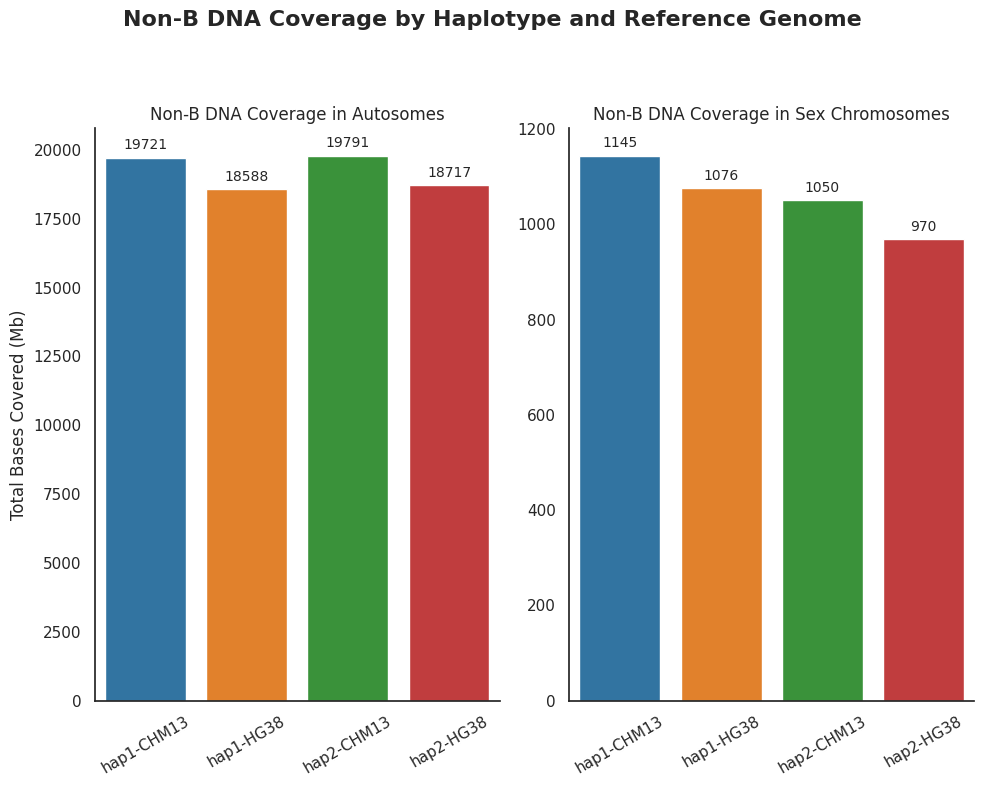

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# =========================================================
# Part 1: Load and Prepare Data
# =========================================================

def load_data(batches, reference):
    dfs = []
    for batch in batches:
        file_path = f'/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/{reference}_Q19_filtered/verkko_batch{batch}_{reference}_collapsed_summary_metrics_chr.csv'
        df = pd.read_csv(file_path)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def prepare_coverage_data(data):
    data = data.copy()
    split_cols = data['Sample_Haplotype_Chromosome'].str.split('|', expand=True)
    data['Sample_Haplotype'] = split_cols[0]
    data['Chromosome'] = split_cols[2]
    data['Haplotype'] = data['Sample_Haplotype'].str.extract(r'(hap\d)')[0]
    return data

def load_quad_data(reference):
    quad_path = f'/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/{reference}_Q19_filtered/verkko_batch123_{reference}_collapsed_quadron_summary_metrics_combined_chr.csv'
    quad_df = pd.read_csv(quad_path)
    quad_df['Label'] = reference.upper()
    return quad_df

def prepare_quad_data(data):
    data = data.copy()
    data['Haplotype'] = data['Sample_Haplotype'].str.extract(r'(hap\d)')[0]
    return data

# === Load & prepare ===
batches = [1, 2, 3]
hg38_data = load_data(batches, 'hg38')
chm13_data = load_data(batches, 'chm13')
hg38_quad = load_quad_data('hg38')
chm13_quad = load_quad_data('chm13')

hg38_data = prepare_coverage_data(hg38_data)
chm13_data = prepare_coverage_data(chm13_data)
hg38_quad = prepare_quad_data(hg38_quad)
chm13_quad = prepare_quad_data(chm13_quad)

# =========================================================
# Part 2: Combine and Summarize
# =========================================================

# Group motif types
hg38_base = hg38_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()
chm13_base = chm13_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()
hg38_quad = hg38_quad.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()
chm13_quad = chm13_quad.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()

# Add labels
hg38_base['Reference Genome'] = 'HG38'
hg38_quad['Reference Genome'] = 'HG38'
chm13_base['Reference Genome'] = 'CHM13'
chm13_quad['Reference Genome'] = 'CHM13'

# Combine
all_data = pd.concat([hg38_base, chm13_base, hg38_quad, chm13_quad], ignore_index=True)

# Annotate chromosome type
autosomes = [f'chr{i}' for i in range(1, 23)]
all_data['Chromosome_Type'] = np.where(all_data['Chromosome'].isin(autosomes), 'Autosomes', 'Sex Chromosomes')

# Convert to Mb
all_data['Total Bases Covered (Mb)'] = all_data['Total Bases Covered'] / 1e6

# =========================================================
# Part 3: Summarize Total by Hap × Ref × ChromType
# =========================================================

summed = all_data.groupby(['Haplotype', 'Reference Genome', 'Chromosome_Type'])['Total Bases Covered (Mb)'].sum().reset_index()
summed['Group'] = summed['Haplotype'] + '-' + summed['Reference Genome']

# =========================================================
# Part 4: Plot (Vertical bars, fixed Seaborn warning)
# =========================================================

sns.set(style="white")  # Clean white background
custom_palette = {
    'hap1-CHM13': '#1f77b4',
    'hap1-HG38': '#ff7f0e',
    'hap2-CHM13': '#2ca02c',
    'hap2-HG38': '#d62728'
}

fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=False)

for i, chrom_type in enumerate(['Autosomes', 'Sex Chromosomes']):
    ax = axes[i]
    data = summed[summed['Chromosome_Type'] == chrom_type].copy()

    order = ['hap1-CHM13', 'hap1-HG38', 'hap2-CHM13', 'hap2-HG38']
    data['Group'] = pd.Categorical(data['Group'], categories=order, ordered=True)

    sns.barplot(data=data, x='Group', y='Total Bases Covered (Mb)',
                hue='Group', palette=custom_palette,
                order=order, ax=ax, dodge=False, legend=False)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height * 1.01,
                f"{height:.0f}", ha='center', va='bottom', fontsize=10)

    ax.set_title(f'Non-B DNA Coverage in {chrom_type}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Total Bases Covered (Mb)' if i == 0 else '')
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(axis='x', labelrotation=30)

plt.suptitle('Non-B DNA Coverage by Haplotype and Reference Genome', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('nonb_coverage_by_hap_and_ref.pdf', bbox_inches='tight')
plt.show()

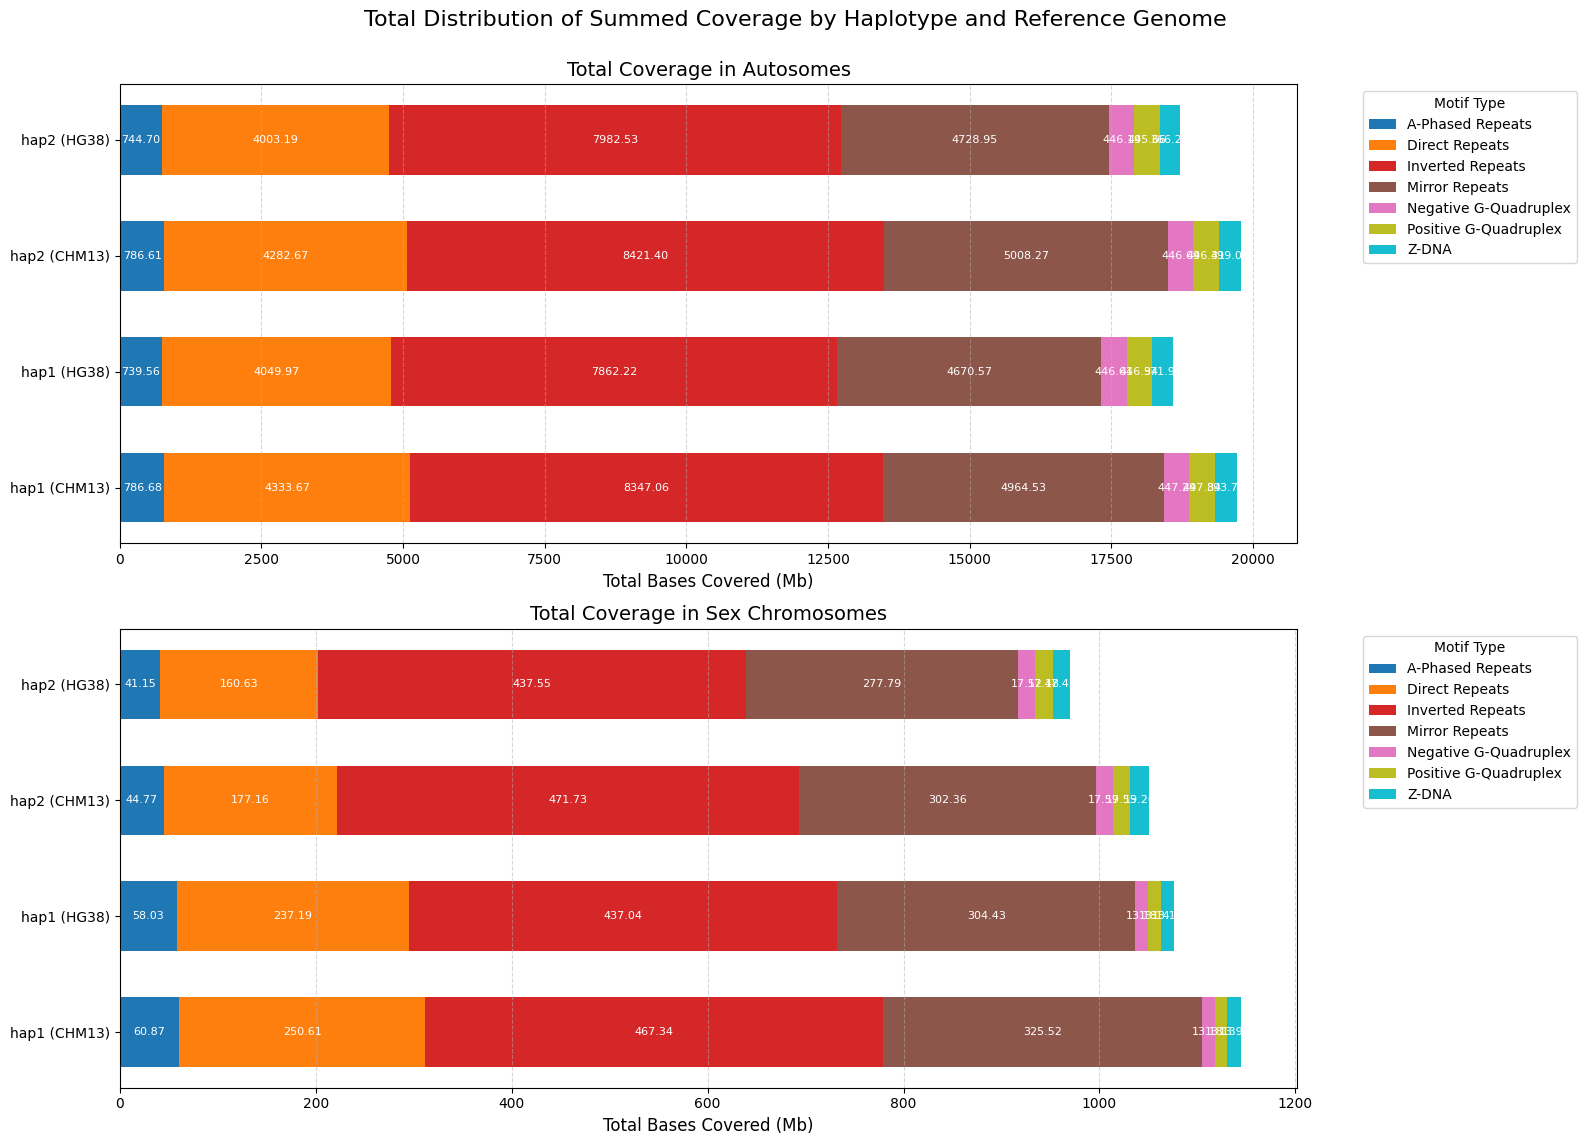

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# Part 1: Data Loading and Preparation
# =========================================================

def load_data(batches, reference):
    """
    Load and concatenate data from multiple batches for a given reference genome.
    """
    dfs = []
    for batch in batches:
        file_path = f'/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/{reference}_Q19_filtered/verkko_batch{batch}_{reference}_collapsed_summary_metrics_chr.csv'
        df = pd.read_csv(file_path)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def prepare_coverage_data(data):
    """
    Prepare coverage data by splitting and extracting relevant columns.
    """
    data = data.copy()
    split_cols = data['Sample_Haplotype_Chromosome'].str.split('|', expand=True)
    data['Sample_Haplotype'] = split_cols[0]
    data['Chromosome'] = split_cols[2]
    data['Haplotype'] = data['Sample_Haplotype'].str.extract(r'(hap\d)')[0]
    return data

def load_quad_data(reference):
    """
    Load and prepare quad data for a given reference genome.
    """
    quad_path = f'/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/{reference}_Q19_filtered/verkko_batch123_{reference}_collapsed_quadron_summary_metrics_combined_chr.csv'
    quad_df = pd.read_csv(quad_path)
    quad_df['Label'] = reference.upper()
    return quad_df

def prepare_quad_data(data):
    """
    Prepare quad data by extracting the haplotype.
    """
    data = data.copy()
    data['Haplotype'] = data['Sample_Haplotype'].str.extract(r'(hap\d)')[0]
    return data

# Load data
batches = [1, 2, 3]
hg38_data = load_data(batches, 'hg38')
chm13_data = load_data(batches, 'chm13')

hg38_quad_data = load_quad_data('hg38')
chm13_quad_data = load_quad_data('chm13')

hg38_data = prepare_coverage_data(hg38_data)
chm13_data = prepare_coverage_data(chm13_data)
hg38_quad_data = prepare_quad_data(hg38_quad_data)
chm13_quad_data = prepare_quad_data(chm13_quad_data)

# =========================================================
# Part 2: Aggregation and Combining Data (Using Sum Instead of Mean)
# =========================================================

# Aggregate batch data using sum
hg38_summed = hg38_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome', 'Motif Type'])['Total Bases Covered'].sum().reset_index()
chm13_summed = chm13_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome', 'Motif Type'])['Total Bases Covered'].sum().reset_index()

# Aggregate quad data using sum
hg38_quad_summed = hg38_quad_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome', 'Motif Type'])['Total Bases Covered'].sum().reset_index()
chm13_quad_summed = chm13_quad_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome', 'Motif Type'])['Total Bases Covered'].sum().reset_index()

# Filter quad data by motif type
hg38_quad_positive = hg38_quad_summed[hg38_quad_summed['Motif Type'] == 'Positive_G_Quad'].copy()
chm13_quad_positive = chm13_quad_summed[chm13_quad_summed['Motif Type'] == 'Positive_G_Quad'].copy()
hg38_quad_negative = hg38_quad_summed[hg38_quad_summed['Motif Type'] == 'Negative_G_Quad'].copy()
chm13_quad_negative = chm13_quad_summed[chm13_quad_summed['Motif Type'] == 'Negative_G_Quad'].copy()

# Add reference genome labels
hg38_summed['Reference Genome'] = 'HG38'
chm13_summed['Reference Genome'] = 'CHM13'
hg38_quad_positive['Reference Genome'] = 'HG38'
chm13_quad_positive['Reference Genome'] = 'CHM13'
hg38_quad_negative['Reference Genome'] = 'HG38'
chm13_quad_negative['Reference Genome'] = 'CHM13'

# Combine all data
combined_summed = pd.concat([hg38_summed, chm13_summed], ignore_index=True)
combined_quad_positive = pd.concat([hg38_quad_positive, chm13_quad_positive], ignore_index=True)
combined_quad_negative = pd.concat([hg38_quad_negative, chm13_quad_negative], ignore_index=True)
all_data = pd.concat([combined_summed, combined_quad_positive, combined_quad_negative], ignore_index=True)

# Classify chromosomes into autosomes and sex chromosomes
autosomes = [f'chr{i}' for i in range(1, 23)]
sex_chromosomes = ['chrX', 'chrY']
all_data['Chromosome_Type'] = np.where(all_data['Chromosome'].isin(autosomes), 'Autosomes', 'Sex Chromosomes')

# Convert total bases covered to megabases
all_data['Total Bases Covered (Mb)'] = all_data['Total Bases Covered'] / 1e6

# Map short motif names to full names
motif_name_map = {
    'DR': 'Direct Repeats',
    'MR': 'Mirror Repeats',
    'IR': 'Inverted Repeats',
    'APR': 'A-Phased Repeats',
    'Z': 'Z-DNA',
    'Positive_G_Quad': 'Positive G-Quadruplex',
    'Negative_G_Quad': 'Negative G-Quadruplex'
}
all_data['Motif Type Full'] = all_data['Motif Type'].map(motif_name_map).fillna(all_data['Motif Type'])

# Sum Total Bases Covered per Sample Haplotype and Chromosome Type
summed_data = all_data.groupby(
    ['Sample_Haplotype', 'Haplotype', 'Reference Genome', 'Chromosome_Type', 'Motif Type Full']
)['Total Bases Covered (Mb)'].sum().reset_index()

# Aggregate across haplotypes within each Reference Genome, Haplotype, Chromosome_Type, and Motif Type Full
# This step sums the coverage across all haplotypes (hap1 and hap2) for each group
grouped_data = summed_data.groupby(
    ['Reference Genome', 'Haplotype', 'Chromosome_Type', 'Motif Type Full']
)['Total Bases Covered (Mb)'].sum().reset_index()

# =========================================================
# Part 3: Horizontal Stacked Bar Plots of Total Bases Covered
# =========================================================

# Function to create stacked horizontal bar plots
def plot_stacked_bar(data, chromosome_type, ax):
    """
    Create a stacked horizontal bar plot for a specific chromosome type.

    Parameters:
    - data: DataFrame containing the aggregated data.
    - chromosome_type: String indicating the chromosome type ('Autosomes' or 'Sex Chromosomes').
    - ax: Matplotlib Axes object to plot on.
    """
    # Filter data for the specified chromosome type
    subset = data[data['Chromosome_Type'] == chromosome_type]
    
    # Pivot the data for plotting
    pivot_data = subset.pivot_table(
        index=['Haplotype', 'Reference Genome'],
        columns='Motif Type Full',
        values='Total Bases Covered (Mb)',
        fill_value=0
    )
    
    # Define the desired order for haplotypes and reference genomes
    hap_order = ['hap1', 'hap2']
    ref_order = ['CHM13', 'HG38']
    
    # Create the desired order list
    desired_order = []
    for hap in hap_order:
        for ref in ref_order:
            if (hap, ref) in pivot_data.index:
                desired_order.append((hap, ref))
    
    # Reindex the pivot table to match the desired order
    pivot_data = pivot_data.reindex(desired_order)
    
    # Define motifs and colors
    motifs = pivot_data.columns.tolist()
    colors = plt.cm.tab10(np.linspace(0, 1, len(motifs)))
    
    # Plotting
    bar_positions = np.arange(len(pivot_data.index))
    bar_height = 0.6
    
    left_values = np.zeros(len(pivot_data))
    for motif, color in zip(motifs, colors):
        values = pivot_data[motif].values
        ax.barh(bar_positions, values, left=left_values, height=bar_height, color=color, label=motif)
        # Add annotations
        for i, (left, value) in enumerate(zip(left_values, values)):
            if value > 0:
                ax.text(left + value / 2, i, f"{value:.2f}", va='center', ha='center', color='white', fontsize=8)
        left_values += values
    
    # Set y-axis labels
    y_labels = [f"{hap} ({ref})" for hap, ref in pivot_data.index]
    ax.set_yticks(bar_positions)
    ax.set_yticklabels(y_labels, fontsize=10)
    ax.set_xlabel('Total Bases Covered (Mb)', fontsize=12)
    ax.set_title(f'Total Coverage in {chromosome_type}', fontsize=14)
    
    # Add grid and legend
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.legend(title='Motif Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=False)

# Plot for Autosomes
plot_stacked_bar(grouped_data, 'Autosomes', axes[0])

# Plot for Sex Chromosomes
plot_stacked_bar(grouped_data, 'Sex Chromosomes', axes[1])

# Adjust layout and add overall title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Total Distribution of Summed Coverage by Haplotype and Reference Genome', fontsize=16)

plt.savefig('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/imgs/summed_haplotype_base_coverage.pdf', bbox_inches='tight')


plt.show()

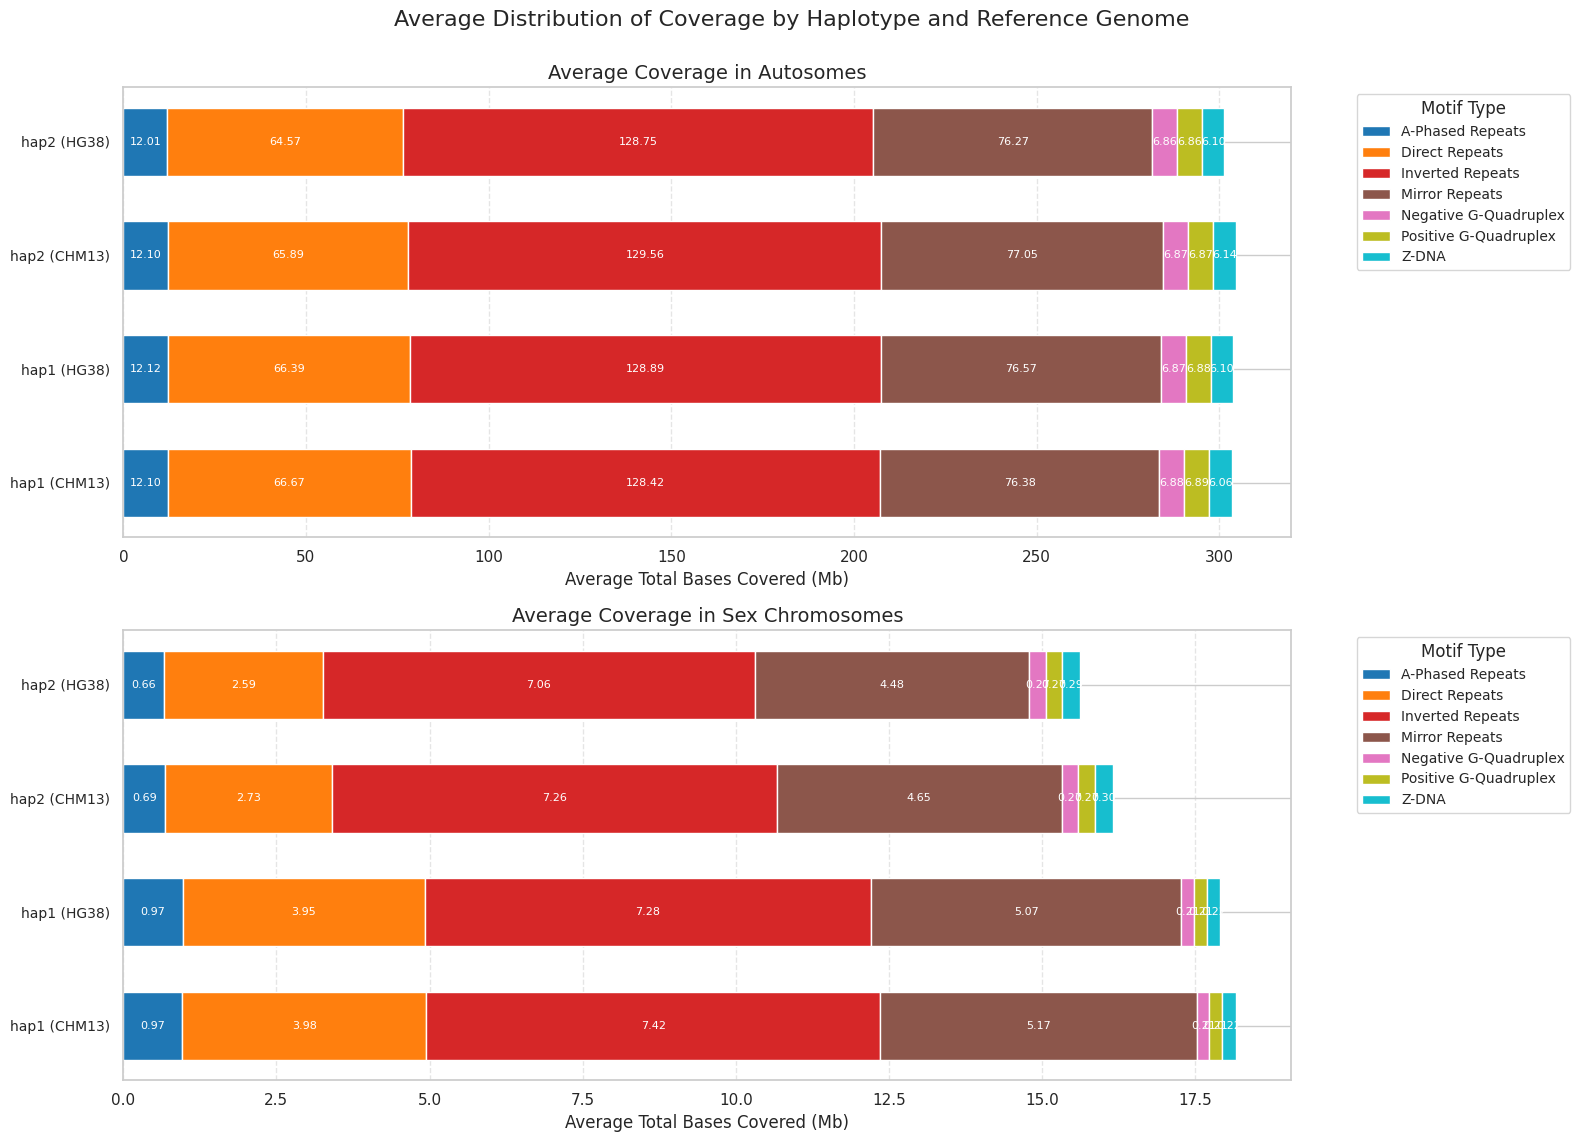

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# Part 1: Data Loading and Preparation
# =========================================================

def load_data(batches, reference):
    """
    Load and concatenate data from multiple batches for a given reference genome.
    """
    dfs = []
    for batch in batches:
        file_path = f'/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/{reference}_Q19_filtered/verkko_batch{batch}_{reference}_collapsed_summary_metrics_chr.csv'
        df = pd.read_csv(file_path)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def prepare_coverage_data(data):
    """
    Prepare coverage data by splitting and extracting relevant columns.
    """
    data = data.copy()
    split_cols = data['Sample_Haplotype_Chromosome'].str.split('|', expand=True)
    data['Sample_Haplotype'] = split_cols[0]
    data['Chromosome'] = split_cols[2]
    data['Haplotype'] = data['Sample_Haplotype'].str.extract(r'(hap\d)')[0]
    return data

def load_quad_data(reference):
    """
    Load and prepare quad data for a given reference genome.
    """
    quad_path = f'//home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/{reference}_Q19_filtered/verkko_batch123_{reference}_collapsed_quadron_summary_metrics_combined_chr.csv'
    quad_df = pd.read_csv(quad_path)
    quad_df['Label'] = reference.upper()
    return quad_df

def prepare_quad_data(data):
    """
    Prepare quad data by extracting the haplotype.
    """
    data = data.copy()
    data['Haplotype'] = data['Sample_Haplotype'].str.extract(r'(hap\d)')[0]
    return data

# Load data
batches = [1, 2, 3]
hg38_data = load_data(batches, 'hg38')
chm13_data = load_data(batches, 'chm13')

hg38_quad_data = load_quad_data('hg38')
chm13_quad_data = load_quad_data('chm13')

hg38_data = prepare_coverage_data(hg38_data)
chm13_data = prepare_coverage_data(chm13_data)
hg38_quad_data = prepare_quad_data(hg38_quad_data)
chm13_quad_data = prepare_quad_data(chm13_quad_data)

# =========================================================
# Part 2: Aggregation and Combining Data (Sum Then Average)
# =========================================================

# Aggregate batch data using sum
hg38_summed = hg38_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome', 'Motif Type'])['Total Bases Covered'].sum().reset_index()
chm13_summed = chm13_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome', 'Motif Type'])['Total Bases Covered'].sum().reset_index()

# Aggregate quad data using sum
hg38_quad_summed = hg38_quad_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome', 'Motif Type'])['Total Bases Covered'].sum().reset_index()
chm13_quad_summed = chm13_quad_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome', 'Motif Type'])['Total Bases Covered'].sum().reset_index()

# Filter quad data by motif type
hg38_quad_positive = hg38_quad_summed[hg38_quad_summed['Motif Type'] == 'Positive_G_Quad'].copy()
chm13_quad_positive = chm13_quad_summed[chm13_quad_summed['Motif Type'] == 'Positive_G_Quad'].copy()
hg38_quad_negative = hg38_quad_summed[hg38_quad_summed['Motif Type'] == 'Negative_G_Quad'].copy()
chm13_quad_negative = chm13_quad_summed[chm13_quad_summed['Motif Type'] == 'Negative_G_Quad'].copy()

# Add reference genome labels
hg38_summed['Reference Genome'] = 'HG38'
chm13_summed['Reference Genome'] = 'CHM13'
hg38_quad_positive['Reference Genome'] = 'HG38'
chm13_quad_positive['Reference Genome'] = 'CHM13'
hg38_quad_negative['Reference Genome'] = 'HG38'
chm13_quad_negative['Reference Genome'] = 'CHM13'

# Combine all data
combined_summed = pd.concat([hg38_summed, chm13_summed], ignore_index=True)
combined_quad_positive = pd.concat([hg38_quad_positive, chm13_quad_positive], ignore_index=True)
combined_quad_negative = pd.concat([hg38_quad_negative, chm13_quad_negative], ignore_index=True)
all_data = pd.concat([combined_summed, combined_quad_positive, combined_quad_negative], ignore_index=True)

# Classify chromosomes into autosomes and sex chromosomes
autosomes = [f'chr{i}' for i in range(1, 23)]
sex_chromosomes = ['chrX', 'chrY']
all_data['Chromosome_Type'] = np.where(all_data['Chromosome'].isin(autosomes), 'Autosomes', 'Sex Chromosomes')

# Convert total bases covered to megabases
all_data['Total Bases Covered (Mb)'] = all_data['Total Bases Covered'] / 1e6

# Map short motif names to full names
motif_name_map = {
    'DR': 'Direct Repeats',
    'MR': 'Mirror Repeats',
    'IR': 'Inverted Repeats',
    'APR': 'A-Phased Repeats',
    'Z': 'Z-DNA',
    'Positive_G_Quad': 'Positive G-Quadruplex',
    'Negative_G_Quad': 'Negative G-Quadruplex'
}
all_data['Motif Type Full'] = all_data['Motif Type'].map(motif_name_map).fillna(all_data['Motif Type'])

# Sum Total Bases Covered per Sample Haplotype and Chromosome Type
summed_data = all_data.groupby(
    ['Sample_Haplotype', 'Haplotype', 'Reference Genome', 'Chromosome_Type', 'Motif Type Full']
)['Total Bases Covered (Mb)'].sum().reset_index()

# Now, aggregate across haplotypes within each Reference Genome, Haplotype, Chromosome_Type, and Motif Type Full
# This step calculates the average coverage across all samples within each group
grouped_data = summed_data.groupby(
    ['Reference Genome', 'Haplotype', 'Chromosome_Type', 'Motif Type Full']
)['Total Bases Covered (Mb)'].mean().reset_index()

# =========================================================
# Part 3: Horizontal Stacked Bar Plots of Average Total Bases Covered
# =========================================================

# Function to create stacked horizontal bar plots
def plot_stacked_bar(data, chromosome_type, ax):
    """
    Create a stacked horizontal bar plot for a specific chromosome type.
    
    Parameters:
    - data: DataFrame containing the aggregated data.
    - chromosome_type: String indicating the chromosome type ('Autosomes' or 'Sex Chromosomes').
    - ax: Matplotlib Axes object to plot on.
    """
    # Filter data for the specified chromosome type
    subset = data[data['Chromosome_Type'] == chromosome_type]
    
    # Pivot the data for plotting
    pivot_data = subset.pivot_table(
        index=['Haplotype', 'Reference Genome'],
        columns='Motif Type Full',
        values='Total Bases Covered (Mb)',
        fill_value=0
    )
    
    # Define the desired order for haplotypes and reference genomes
    hap_order = ['hap1', 'hap2']
    ref_order = ['CHM13', 'HG38']
    
    # Create the desired order list
    desired_order = []
    for hap in hap_order:
        for ref in ref_order:
            if (hap, ref) in pivot_data.index:
                desired_order.append((hap, ref))
    
    # Reindex the pivot table to match the desired order
    pivot_data = pivot_data.reindex(desired_order)
    
    # Define motifs and colors
    motifs = pivot_data.columns.tolist()
    colors = plt.cm.tab10(np.linspace(0, 1, len(motifs)))
    
    # Plotting
    bar_positions = np.arange(len(pivot_data.index))
    bar_height = 0.6
    
    left_values = np.zeros(len(pivot_data))
    for motif, color in zip(motifs, colors):
        values = pivot_data[motif].values
        ax.barh(bar_positions, values, left=left_values, height=bar_height, color=color, label=motif)
        # Add annotations
        for i, (left, value) in enumerate(zip(left_values, values)):
            if value > 0:
                ax.text(left + value / 2, i, f"{value:.2f}", va='center', ha='center', color='white', fontsize=8)
        left_values += values
    
    # Set y-axis labels
    y_labels = [f"{hap} ({ref})" for hap, ref in pivot_data.index]
    ax.set_yticks(bar_positions)
    ax.set_yticklabels(y_labels, fontsize=10)
    ax.set_xlabel('Average Total Bases Covered (Mb)', fontsize=12)
    ax.set_title(f'Average Coverage in {chromosome_type}', fontsize=14)
    
    # Add grid and legend
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.legend(title='Motif Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=False)

# Plot for Autosomes
plot_stacked_bar(grouped_data, 'Autosomes', axes[0])

# Plot for Sex Chromosomes
plot_stacked_bar(grouped_data, 'Sex Chromosomes', axes[1])

# Adjust layout and add overall title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Average Distribution of Coverage by Haplotype and Reference Genome', fontsize=16)

plt.show()

    Sample_Haplotype       Motif Type  Total Count  Total Bases Covered  \
0       HG00096_hap1  Negative_G_Quad       176040              6810163   
1       HG00096_hap1                Z       410920              6174103   
2       HG00096_hap1               IR      5863251            135443713   
3       HG00096_hap1              APR       526425             12903944   
4       HG00096_hap1               MR      1377859             81793345   
..               ...              ...          ...                  ...   
870     NA20847_hap2               DR      1606753             66818194   
871     NA20847_hap2  Negative_G_Quad       183363              7048575   
872     NA20847_hap2                Z       425278              6428065   
873     NA20847_hap2  Positive_G_Quad       184186              7065235   
874     NA20847_hap2              APR       508762             12547437   

     Percent of Genome   Sample Haplotype Sample name     Sex  \
0             0.236191  HG00096   

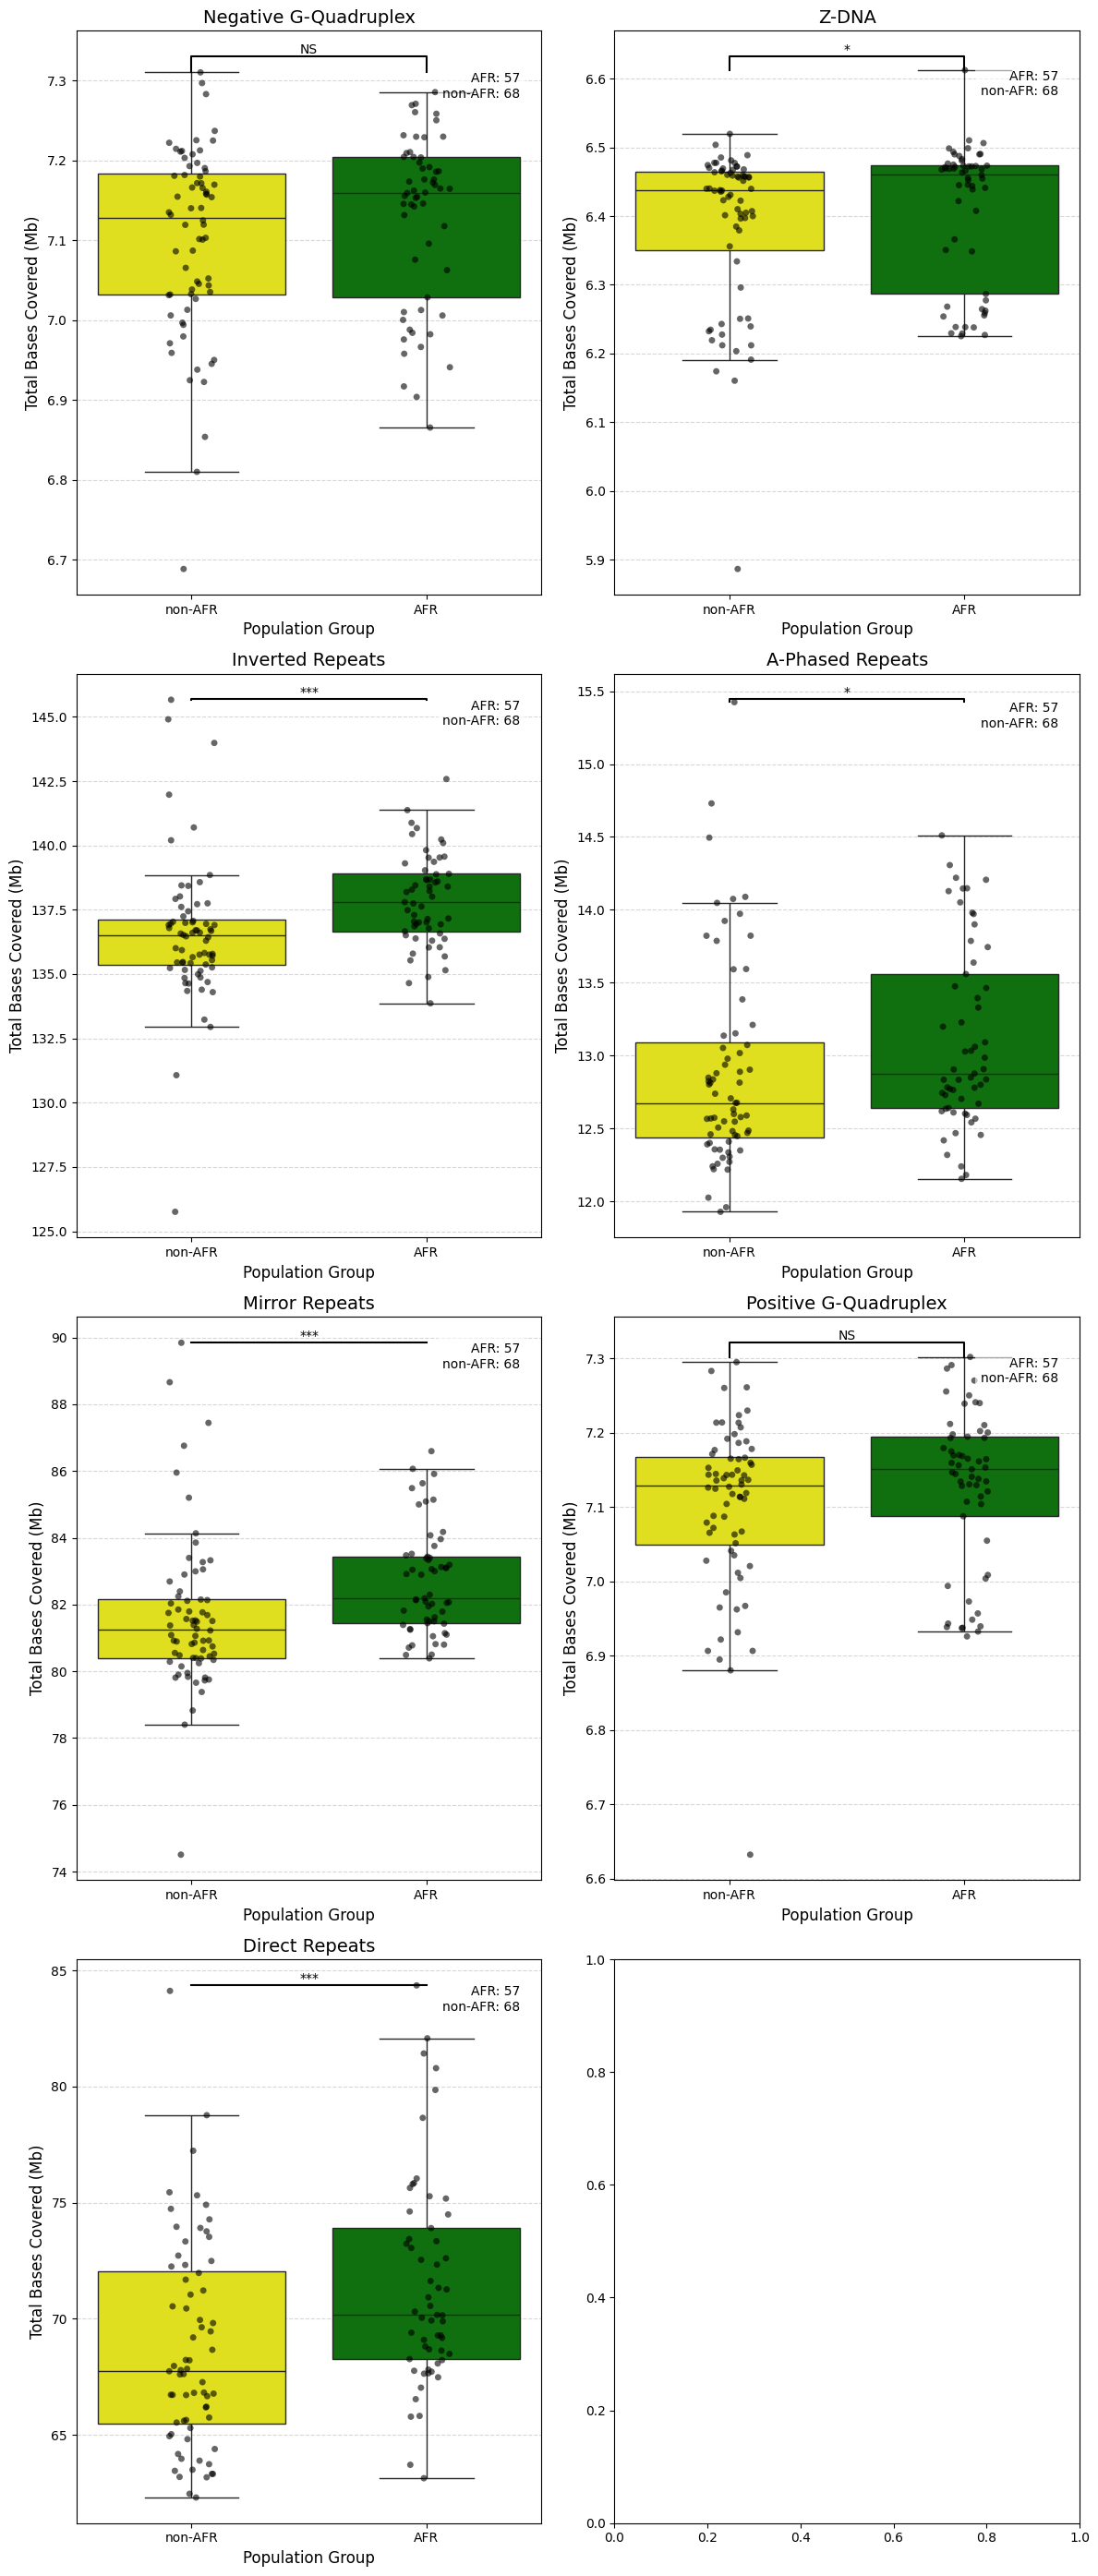

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Load your feature counts dataframes
batch1 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch1_chm13_collapsed_summary_metrics.csv')
batch2 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch2_chm13_collapsed_summary_metrics.csv')
batch3 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch3_chm13_collapsed_summary_metrics.csv')
batch4 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv')

# Combine the dataframes
df = pd.concat([batch1, batch2, batch3, batch4], ignore_index=True)

# Extract sample identifier (e.g., HG#### or NA####) and haplotype from 'Sample_Haplotype' column
df[['Sample', 'Haplotype']] = df['Sample_Haplotype'].str.split('_', expand=True)

# List of values to filter out
values_to_exclude = ['NA20355_hap1', 'NA21487_hap1', 'NA21487_hap2', 'NA24385_hap1', 'NA24385_hap2']  # Add as many as needed

# Use .isin() to filter out multiple values
df = df[~df['Sample_Haplotype'].isin(values_to_exclude)]

# Sort by 'Sample_Haplotype'
sorted_df = df.sort_values(by='Sample_Haplotype')

# Assuming the metadata file is already read into metadata_df
metadata_df = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/igsr_samples.tsv', delimiter='\t')

# Merge metadata with the sorted DataFrame on 'Sample' column
merged_df = pd.merge(sorted_df, metadata_df[['Sample name', 'Sex', 'Superpopulation name', 'Superpopulation code']], left_on='Sample', right_on='Sample name', how='left')
print(merged_df)
# Group non-AFR populations together
merged_df['Population Group'] = merged_df['Superpopulation code'].apply(lambda x: 'AFR' if x == 'AFR' else 'non-AFR')

# Convert 'Total Bases Covered' to Megabases
merged_df['Total Bases Covered (Mb)'] = merged_df['Total Bases Covered'] / 1_000_000

# Define a color palette
palette = {'AFR': 'green', 'non-AFR': 'yellow'}

# Map short motif names to full names
motif_name_map = {
    'DR': 'Direct Repeats',
    'MR': 'Mirror Repeats',
    'IR': 'Inverted Repeats',
    'APR': 'A-Phased Repeats',
    'Z': 'Z-DNA',
    'Positive_G_Quad': 'Positive G-Quadruplex',
    'Negative_G_Quad': 'Negative G-Quadruplex'
}

# Function to add significance annotation
def add_significance_annotation(ax, p_value, x1, x2, y, h, col):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    if p_value < 0.001:
        significance_text = '***'
    elif p_value < 0.01:
        significance_text = '**'
    elif p_value < 0.05:
        significance_text = '*'
    else:
        significance_text = 'NS'
    ax.text((x1 + x2) * .5, y + h, significance_text, ha='center', va='bottom', color=col)

# Create subplots
motif_types = merged_df['Motif Type'].unique()
num_motifs = len(motif_types)
fig, axes = plt.subplots(nrows=num_motifs // 2 + num_motifs % 2, ncols=2, figsize=(12, num_motifs * 4))

# Flatten axes array in case there's only one row of plots
axes = axes.flatten()

# Plot for each motif type
for idx, motif in enumerate(motif_types):
    motif_df = merged_df[merged_df['Motif Type'] == motif]
    
    # Create boxplot using seaborn
    ax = sns.boxplot(data=motif_df, x='Population Group', y='Total Bases Covered (Mb)', hue='Population Group', palette=palette, dodge=False, showfliers=False, ax=axes[idx])
    # Add jittered stripplot
    sns.stripplot(data=motif_df, x='Population Group', y='Total Bases Covered (Mb)', hue='Population Group', 
                  palette=['black']*2, dodge=False, jitter=True, size=5, marker='o', alpha=0.6, ax=ax)

    # Customize plot
    ax.set_xlabel('Population Group', fontsize=12)
    ax.set_ylabel('Total Bases Covered (Mb)', fontsize=12)
    ax.set_title(f'{motif_name_map.get(motif, motif)}', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend([], [], frameon=False)  # Remove legend from subplot
    
    # Perform Mann-Whitney U test
    afr_data = motif_df[motif_df['Population Group'] == 'AFR']['Total Bases Covered (Mb)']
    non_afr_data = motif_df[motif_df['Population Group'] == 'non-AFR']['Total Bases Covered (Mb)']
    _, p_value_total_bases = mannwhitneyu(afr_data, non_afr_data)
    
    # Add significance annotation
    add_significance_annotation(ax, p_value_total_bases, 0, 1, motif_df['Total Bases Covered (Mb)'].max(), 0.02, 'black')
    
    # Calculate unique sample_haplotype counts for AFR and non-AFR
    afr_sample_haplotypes = motif_df[motif_df['Population Group'] == 'AFR']['Sample_Haplotype'].nunique()
    non_afr_sample_haplotypes = motif_df[motif_df['Population Group'] == 'non-AFR']['Sample_Haplotype'].nunique()
    
    # Add annotations for sample_haplotype counts
    ax.text(1.4, motif_df['Total Bases Covered (Mb)'].max(), f"AFR: {afr_sample_haplotypes}\nnon-AFR: {non_afr_sample_haplotypes}", 
            ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Adjust layout
plt.tight_layout()

# Save the entire figure as one high-resolution image
plt.savefig('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/imgs/AFR_NONAFR_base_coverage_whole_genome_combined.pdf', bbox_inches='tight', dpi=300)

# Show plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Load your feature counts dataframes
batch1 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch1_chm13_collapsed_summary_metrics.csv')
batch2 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch2_chm13_collapsed_summary_metrics.csv')
batch3 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch3_chm13_collapsed_summary_metrics.csv')
batch4 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv')

df = pd.concat([batch1, batch2, batch3, batch4], ignore_index=True)
df[['Sample', 'Haplotype']] = df['Sample_Haplotype'].str.split('_', expand=True)

values_to_exclude = ['NA20355_hap1', 'NA21487_hap1', 'NA21487_hap2', 'NA24385_hap1', 'NA24385_hap2']
df = df[~df['Sample_Haplotype'].isin(values_to_exclude)]
sorted_df = df.sort_values(by='Sample_Haplotype')

metadata_df = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/igsr_samples.tsv', delimiter='\t')
merged_df = pd.merge(sorted_df, metadata_df[['Sample name', 'Sex', 'Superpopulation name', 'Superpopulation code']], 
                     left_on='Sample', right_on='Sample name', how='left')

merged_df['Population Group'] = merged_df['Superpopulation code'].apply(lambda x: 'AFR' if x == 'AFR' else 'non-AFR')
merged_df['Total Bases Covered (Mb)'] = merged_df['Total Bases Covered'] / 1_000_000

palette = {'AFR': 'green', 'non-AFR': 'yellow'}
motif_name_map = {
    'DR': 'Direct Repeats',
    'MR': 'Mirror Repeats',
    'IR': 'Inverted Repeats',
    'APR': 'A-Phased Repeats',
    'Z': 'Z-DNA',
    'Positive_G_Quad': 'Positive G-Quadruplex',
    'Negative_G_Quad': 'Negative G-Quadruplex'
}

def add_significance_annotation(ax, p_value, x1, x2, y, h, col):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    if p_value < 0.001:
        significance_text = '***'
    elif p_value < 0.01:
        significance_text = '**'
    elif p_value < 0.05:
        significance_text = '*'
    else:
        significance_text = 'NS'
    ax.text((x1 + x2) * .5, y + h, significance_text, ha='center', va='bottom', color=col, fontsize=14)

# === OPTIONAL: filter motifs here ===
motif_types = ['IR', 'Positive_G_Quad']  # <-- Only these two motifs will be plotted
# motif_types = merged_df['Motif Type'].unique()  # <-- Uncomment this to do all motifs

num_motifs = len(motif_types)
fig, axes = plt.subplots(nrows=num_motifs // 2 + num_motifs % 2, ncols=2, figsize=(12, num_motifs * 4))
axes = axes.flatten()

for idx, motif in enumerate(motif_types):
    motif_df = merged_df[merged_df['Motif Type'] == motif]

    ax = sns.boxplot(data=motif_df, x='Population Group', y='Total Bases Covered (Mb)', 
                     hue='Population Group', palette=palette, dodge=False, showfliers=False, ax=axes[idx])
    
    sns.stripplot(data=motif_df, x='Population Group', y='Total Bases Covered (Mb)', 
                  hue='Population Group', palette=['black']*2, dodge=False, jitter=True, size=5, marker='o', alpha=0.6, ax=ax)

    ax.set_xlabel('Population Group', fontsize=14)
    ax.set_ylabel('Total Bases Covered (Mb)', fontsize=14)
    ax.set_title(f'{motif_name_map.get(motif, motif)}', fontsize=16, weight='bold')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.grid(False)  # Remove gridlines
    ax.legend([], [], frameon=False)

    afr_data = motif_df[motif_df['Population Group'] == 'AFR']['Total Bases Covered (Mb)']
    non_afr_data = motif_df[motif_df['Population Group'] == 'non-AFR']['Total Bases Covered (Mb)']
    _, p_value_total_bases = mannwhitneyu(afr_data, non_afr_data)

    y_max = motif_df['Total Bases Covered (Mb)'].max()
    add_significance_annotation(ax, p_value_total_bases, 0, 1, y_max, 0.05 * y_max, 'black')

    afr_sample_haplotypes = motif_df[motif_df['Population Group'] == 'AFR']['Sample_Haplotype'].nunique()
    non_afr_sample_haplotypes = motif_df[motif_df['Population Group'] == 'non-AFR']['Sample_Haplotype'].nunique()
    
    ax.text(1.4, y_max, f"AFR: {afr_sample_haplotypes}\nnon-AFR: {non_afr_sample_haplotypes}", 
            ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/imgs/AFR_NONAFR_base_coverage_whole_genome_combined.pdf', bbox_inches='tight', dpi=300)
plt.show()

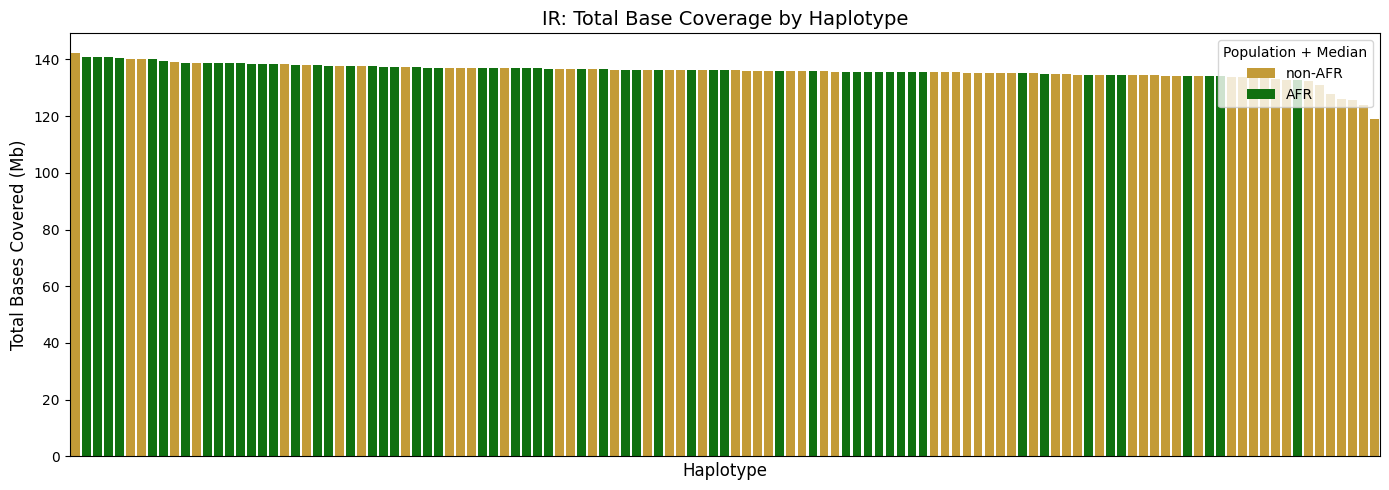

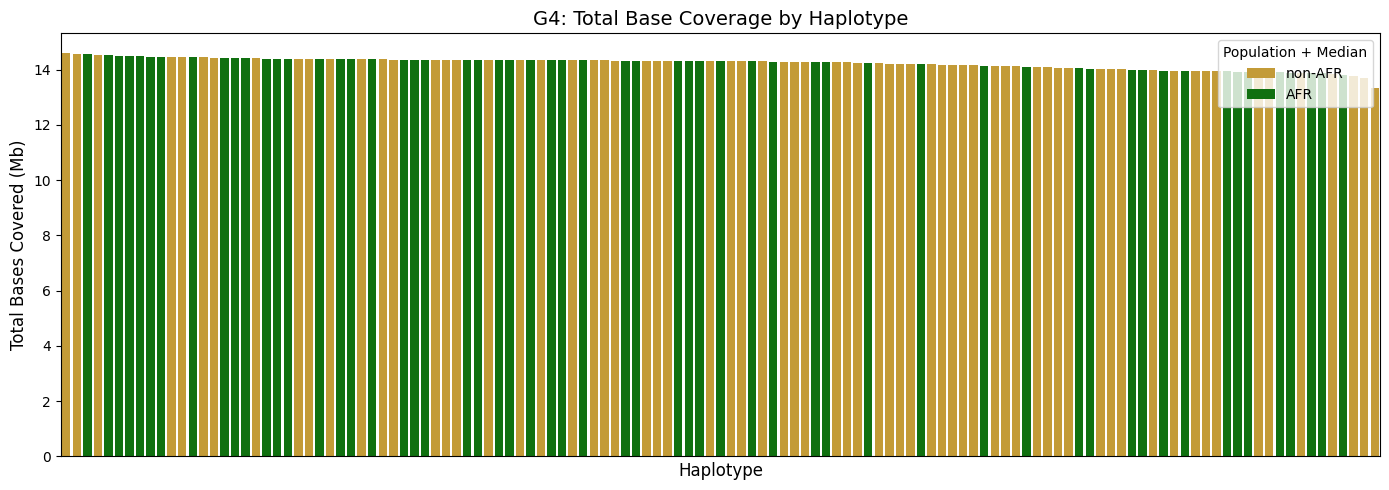

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all batch files
batch1 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch1_hg38_collapsed_summary_metrics.csv')
batch2 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch2_hg38_collapsed_summary_metrics.csv')
batch3 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch3_hg38_collapsed_summary_metrics.csv')
batch4 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv')

# === Combine batches
df = pd.concat([batch1, batch2, batch3, batch4], ignore_index=True)
df[['Sample', 'Haplotype']] = df['Sample_Haplotype'].str.split('_', expand=True)

# === Exclude specific haplotypes
excluded = ['NA20355_hap1', 'NA21487_hap1', 'NA21487_hap2', 'NA24385_hap1', 'NA24385_hap2']
df = df[~df['Sample_Haplotype'].isin(excluded)]

# === Load metadata and merge
metadata = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/igsr_samples.tsv', sep='\t')
df = df.merge(metadata[['Sample name', 'Superpopulation code']], left_on='Sample', right_on='Sample name', how='left')
df = df[df['Superpopulation code'].isin(['AFR', 'EUR', 'AMR', 'EAS', 'SAS'])].copy()

df['Population Group'] = df['Superpopulation code'].apply(
    lambda x: 'AFR' if x == 'AFR' else 'non-AFR'
)

# === Convert to Mb
df['Total Bases Covered (Mb)'] = df['Total Bases Covered'] / 1e6

# === Focus only on IR and G4 (combine G4 types)
motifs_of_interest = ['IR', 'Positive_G_Quad', 'Negative_G_Quad']
df = df[df['Motif Type'].isin(motifs_of_interest)].copy()

# Classify G4 vs IR
df['Motif Category'] = df['Motif Type'].apply(lambda x: 'G4' if 'Quad' in x else x)

# Aggregate G4s across both strand types
g4_df = df[df['Motif Category'] == 'G4'].groupby(['Sample_Haplotype', 'Sample', 'Population Group'])['Total Bases Covered (Mb)'].sum().reset_index()
g4_df['Motif Category'] = 'G4'

# Keep IRs as-is
ir_df = df[df['Motif Category'] == 'IR'][['Sample_Haplotype', 'Sample', 'Population Group', 'Total Bases Covered (Mb)', 'Motif Category']]

# Merge
df = pd.concat([ir_df, g4_df], ignore_index=True)

# === Barplot function (sorted by base coverage)
def plot_barplot(data, motif_type, output_path):
    motif_df = data[data['Motif Category'] == motif_type].copy()

    # Sort by total base coverage only
    motif_df = motif_df.sort_values(by='Total Bases Covered (Mb)', ascending=False)

    palette = {'AFR': 'green', 'non-AFR': 'goldenrod'}

    plt.figure(figsize=(14, 5))
    sns.barplot(
        data=motif_df,
        x='Sample_Haplotype',
        y='Total Bases Covered (Mb)',
        hue='Population Group',
        palette=palette,
        dodge=False
    )

    plt.xticks([], [])
    plt.xlabel('Haplotype', fontsize=12)
    plt.ylabel('Total Bases Covered (Mb)', fontsize=12)
    plt.title(f'{motif_type}: Total Base Coverage by Haplotype', fontsize=14)

    plt.legend(title='Population + Median', loc='upper right')
    plt.tight_layout()
    ##plt.savefig(output_path, dpi=300)
    plt.show()

# === Run plots
plot_barplot(df, 'IR', '/home/alextu/IR_sorted_by_value_with_medians.pdf')
plot_barplot(df, 'G4', '/home/alextu/G4_sorted_by_value_with_medians.pdf')

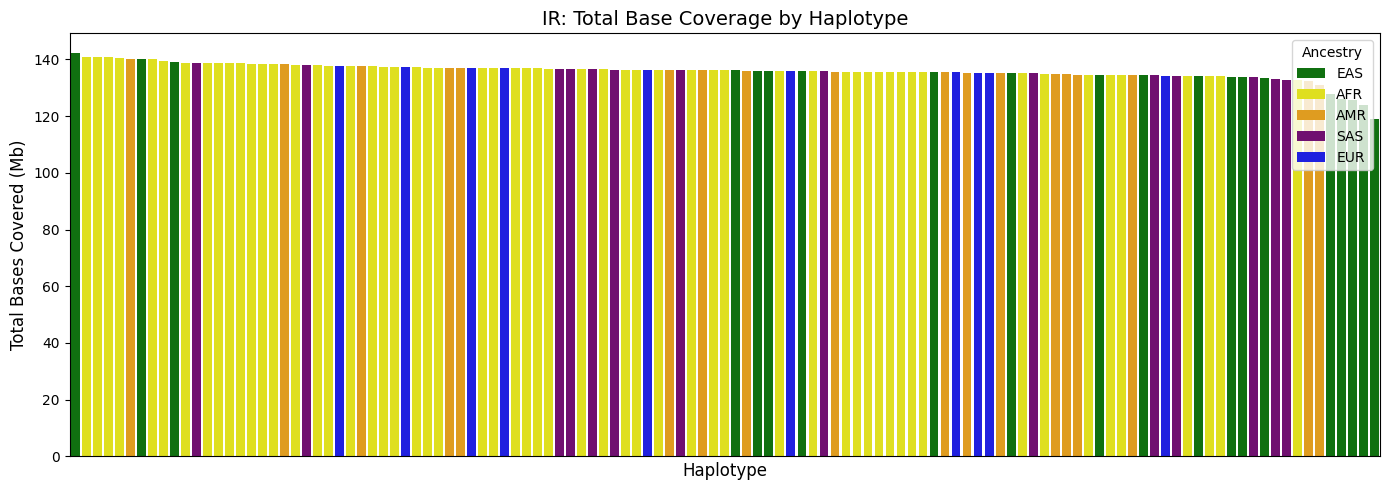

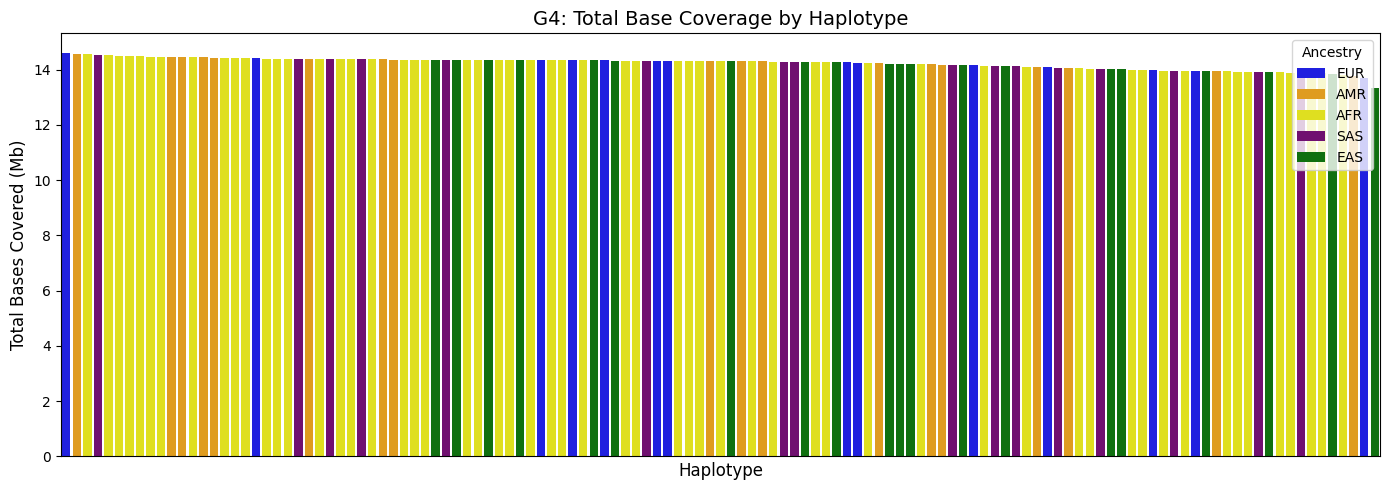

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all batch files
batch1 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch1_hg38_collapsed_summary_metrics.csv')
batch2 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch2_hg38_collapsed_summary_metrics.csv')
batch3 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch3_hg38_collapsed_summary_metrics.csv')
batch4 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv')

# === Combine batches
df = pd.concat([batch1, batch2, batch3, batch4], ignore_index=True)
df[['Sample', 'Haplotype']] = df['Sample_Haplotype'].str.split('_', expand=True)

# === Exclude specific haplotypes
excluded = ['NA20355_hap1', 'NA21487_hap1', 'NA21487_hap2', 'NA24385_hap1', 'NA24385_hap2']
df = df[~df['Sample_Haplotype'].isin(excluded)]

# === Load metadata and merge
metadata = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/igsr_samples.tsv', sep='\t')
df = df.merge(metadata[['Sample name', 'Superpopulation code']], left_on='Sample', right_on='Sample name', how='left')
df = df[df['Superpopulation code'].isin(['AFR', 'EUR', 'AMR', 'EAS', 'SAS'])].copy()

# === Define ancestry-specific color palette
palette = {
    'AFR': 'yellow',
    'EAS': 'green',
    'AMR': 'orange',
    'EUR': 'blue',
    'SAS': 'purple'
}

# === Convert to Mb
df['Total Bases Covered (Mb)'] = df['Total Bases Covered'] / 1e6

# === Focus only on IR and G4 (combine G4 types)
motifs_of_interest = ['IR', 'Positive_G_Quad', 'Negative_G_Quad']
df = df[df['Motif Type'].isin(motifs_of_interest)].copy()

# === Classify G4 vs IR
df['Motif Category'] = df['Motif Type'].apply(lambda x: 'G4' if 'Quad' in x else x)

# === Aggregate G4s across both strand types
g4_df = df[df['Motif Category'] == 'G4'].groupby(['Sample_Haplotype', 'Sample', 'Superpopulation code'])['Total Bases Covered (Mb)'].sum().reset_index()
g4_df['Motif Category'] = 'G4'

# === Keep IRs as-is
ir_df = df[df['Motif Category'] == 'IR'][['Sample_Haplotype', 'Sample', 'Superpopulation code', 'Total Bases Covered (Mb)', 'Motif Category']]

# === Merge IR + G4
df = pd.concat([ir_df, g4_df], ignore_index=True)

# === Barplot function (sorted by base coverage)
def plot_barplot(data, motif_type, output_path):
    motif_df = data[data['Motif Category'] == motif_type].copy()

    # Sort by total base coverage
    motif_df = motif_df.sort_values(by='Total Bases Covered (Mb)', ascending=False)

    plt.figure(figsize=(14, 5))
    sns.barplot(
        data=motif_df,
        x='Sample_Haplotype',
        y='Total Bases Covered (Mb)',
        hue='Superpopulation code',
        palette=palette,
        dodge=False
    )

    plt.xticks([], [])
    plt.xlabel('Haplotype', fontsize=12)
    plt.ylabel('Total Bases Covered (Mb)', fontsize=12)
    plt.title(f'{motif_type}: Total Base Coverage by Haplotype', fontsize=14)

    plt.legend(title='Ancestry', loc='upper right')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()

# === Run plots
plot_barplot(df, 'IR', '/home/alextu/IR_sorted_by_value_with_ancestry.pdf')
plot_barplot(df, 'G4', '/home/alextu/G4_sorted_by_value_with_ancestry.pdf')